In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

### Pytorch Model Explainability with Captum

In [2]:
###### https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/ #################
# with modifications and GPU acceleration by Mark J Bennett mbennett@nvidia.com and Emanuel Scoullos escoullos@nvidia.com

###### Best when compared to:
###### https://www.bankofengland.co.uk/-/media/boe/files/working-paper/2019/
######        machine-learning-explainability-in-finance-an-application-to-default-risk-analysis.pdf
%matplotlib inline

from collections import OrderedDict
import gc
import glob
import os
import pickle
import re
import sys
import time
from typing import Union

import cupy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
                             precision_score, recall_score, precision_recall_curve, f1_score, 
                             accuracy_score)

from tqdm.autonotebook import tqdm
import xgboost as xgb

start_time = time.time()

    

from clfmodel import binaryClassification

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# make sure the path below points to the data directory where the FannieMae data was downloaded.
if os.getcwd() != '/rapids/notebooks/cleaned_data':
    os.chdir('/rapids/notebooks/cleaned_data')

figures_path = '/rapids/notebooks/figures'

sns.set()

/tmp/ipykernel_571548/1293066298.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Note plots may look slightly different since we trained 2 models.
################################################################
# choice of using NVTabular or Pytorch
use_nvtabular = False  # NVTabular only will work for GPU
use_cpu = False # choice of False (for GPU) or True (for CPU)

################################################################

if use_cpu:
    from pandas import read_parquet, concat, merge, DataFrame, get_dummies, Series, isnull
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from numpy import zeros, double, int8, int16, int64, concatenate
else:
    from cudf import read_parquet, concat, merge, DataFrame, get_dummies, Series
    from cupy import zeros,double, int8, int16, int64, concatenate
    from cuml.model_selection import train_test_split
    from cuml.preprocessing import OneHotEncoder, StandardScaler
    from cuml.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score

In [4]:
with open('fnma_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
# print('\n'.join(mappings.keys()))

cards = []
for key in sorted(mappings):
    print(key, len(set(mappings[key])))
    cards.append(len(set(mappings[key])))

Channel 3
FTHomeBuyer 3
LoanPurpose 4
MortInsType 2
OccStatus 3
ProductType 1
PropertyState 54
PropertyType 5
SellerName 49
Zip 961


### Load Model

In [5]:
Xcolumns=['Channel',
         'SellerName',
         'OrInterestRate',
         'OrUnpaidPrinc',
         'OrLoanTerm',
         'OrCLTV',
         'NumBorrow',
         'DTIRat',
         'CreditScore',
         'FTHomeBuyer',
         'LoanPurpose',
         'PropertyType',
         'NumUnits',
         'OccStatus',
         'PropertyState',
         'Zip',
         'ProductType',
         'CoCreditScore',
         'Extra',
         'MortInsType']
CONTINUOUS_COLUMNS = ['OrInterestRate', 'OrUnpaidPrinc', 'OrLoanTerm', 'OrCLTV', 'NumBorrow', 'DTIRat', 
                      'CreditScore', 'NumUnits', 'CoCreditScore', 'Extra']
CATEGORICAL_COLUMNS = sorted([i for i in Xcolumns if i not in CONTINUOUS_COLUMNS])
LABEL_COLUMNS = ['Default']

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim


# params from prior notebook
BATCH_SIZE = 2048
LEARNING_RATE = 0.0001

DEVICE=0
cp.cuda.Device(DEVICE).use()
device = 'cpu' if use_cpu else torch.device(f"cuda:{DEVICE}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:

def load_checkpoint(file_name: str, model, device: str):
    """
    Load Checkpoint from pytorch .pt file.

    Args:
        k_fold: int or string for K-folds.
        device: str
        file_name (str): filename usually including the name of the model.
        model_cls: (uninstantiated) class belonging to a custom nn.Module
        **kwargs:

    Returns:

    """
    # instantiate the model and pass in input params as kwargs.
    model = model.to(device)

    checkpoint = torch.load(f'./checkpoints/{file_name}.pt')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model, checkpoint['threshold']

In [8]:
model = binaryClassification(cat_cards=cards, numer_dims=len(CONTINUOUS_COLUMNS)).to(device)

print(model)
criterion = nn.BCEWithLogitsLoss() # pos_weight=torch.tensor(25, device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

if use_nvtabular:
    model_name = 'fnma_model_mlp_nvt'
else:
    model_name = 'fnma_model_mlp_pyt'
    
model, threshold = load_checkpoint(model_name, model, device)
model = model.to(device)

binaryClassification(
  (layer_1): Linear(in_features=20, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=512, bias=True)
  (layer_4): Linear(in_features=512, out_features=512, bias=True)
  (layer_5): Linear(in_features=512, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=1, bias=True)
  (prelu1): PReLU(num_parameters=1)
  (prelu2): PReLU(num_parameters=1)
  (prelu3): PReLU(num_parameters=1)
  (prelu4): PReLU(num_parameters=1)
  (prelu5): PReLU(num_parameters=1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(512, 

### Load Datasets

In [9]:
cp.cuda.Device(DEVICE).use()

if use_nvtabular and not use_cpu:
    import nvtabular as nvt
    from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader
    
    # these files were saved in the prior notebook. 
    pos_path = 'fnma_pos_test.parquet'
    neg_path = 'fnma_neg_test.parquet'
    
    #  Uncomment below if you want to explore a dataset with combined positive and negative examples
    test_path = 'fnma_test_nvt.parquet'
    test_dataset = TorchAsyncItr(
       nvt.Dataset(test_path),
       cats=CATEGORICAL_COLUMNS,
       conts=CONTINUOUS_COLUMNS,
       labels=LABEL_COLUMNS,
       batch_size=BATCH_SIZE
    )

    test_loader = DLDataLoader(
       test_dataset,
       batch_size=None,
       pin_memory=False,
       num_workers=0
    )

    pos_dataset = TorchAsyncItr(
        nvt.Dataset(pos_path),
        cats=CATEGORICAL_COLUMNS,
        conts=CONTINUOUS_COLUMNS,
        labels=LABEL_COLUMNS,
        batch_size=BATCH_SIZE,
    )

    pos_loader = DLDataLoader(
        pos_dataset,
        batch_size=None,
        pin_memory=False,
        num_workers=0
    )

    neg_dataset = TorchAsyncItr(
        nvt.Dataset(neg_path),
        cats=CATEGORICAL_COLUMNS,
        conts=CONTINUOUS_COLUMNS,
        labels=LABEL_COLUMNS,
        batch_size=BATCH_SIZE,
    )

    neg_loader = DLDataLoader(
        neg_dataset,
        batch_size=None,
        pin_memory=False,
        num_workers=0
    )
    
else:
    from torch.utils.data import Dataset, DataLoader

    class PytData(Dataset):

        def __init__(self, X_data, y_data, cont_cols, cat_cols, device):
            self.X_data_cont = torch.tensor(X_data[cont_cols].as_gpu_matrix(), dtype=torch.float32, device=device)
            self.X_data_cat = torch.tensor(X_data[cat_cols].as_gpu_matrix(), dtype=torch.float32, device=device)

            assert len(cont_cols) == self.X_data_cont.shape[1]
            assert len(cat_cols) == self.X_data_cat.shape[1]

            self.y_data = torch.tensor(y_data, dtype=torch.float32, device=device)

        def __getitem__(self, index):
            return self.X_data_cat[index], self.X_data_cont[index], self.y_data[index]

        def __len__ (self):

            return len(self.y_data)
        
    with open('pos_loader.pkl', 'rb') as f:
        pos_loader = pickle.load(f)
        pos_loader.dataset.X_data_cat = pos_loader.dataset.X_data_cat.to(device)
        pos_loader.dataset.X_data_cont = pos_loader.dataset.X_data_cont.to(device)
        pos_loader.dataset.y_data = pos_loader.dataset.y_data.to(device)

    with open('neg_loader.pkl', 'rb') as f:
        neg_loader = pickle.load(f)
        neg_loader.dataset.X_data_cat = neg_loader.dataset.X_data_cat.to(device)
        neg_loader.dataset.X_data_cont = neg_loader.dataset.X_data_cont.to(device)
        neg_loader.dataset.y_data = neg_loader.dataset.y_data.to(device)

#      Uncomment below if you want to explore a dataset with combined positive and negative examples
    with open('test_loader.pkl', 'rb') as f:
        test_loader = pickle.load(f)
        test_loader.dataset.X_data_cat = test_loader.dataset.X_data_cat.to(device)
        test_loader.dataset.X_data_cont = test_loader.dataset.X_data_cont.to(device)
        test_loader.dataset.y_data = test_loader.dataset.y_data.to(device)


In [10]:
def load_single_batch(loader, device, num_batches=1):
    x_cats_batches = []
    x_cont_batches = []
    for batch_num, (x_cat, x_cont, ybatch) in tqdm(enumerate(loader)):
        
        if batch_num == num_batches:
            break
        x_cats_batches.append(x_cat)
        x_cont_batches.append(x_cont)
    x_cats = torch.cat(x_cats_batches).to(device)
    x_conts = torch.cat(x_cont_batches).to(device)
    return x_cats, x_conts

pos_cats, pos_conts = load_single_batch(pos_loader, device, num_batches=1)
neg_cats, neg_conts = load_single_batch(neg_loader, device, num_batches=1)

#  Uncomment below if you want to explore a dataset with combined positive and negative examples
all_cats, all_conts = load_single_batch(test_loader, device, num_batches=-1)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Captum Explainability

In [11]:
from captum.attr import GradientShap, IntegratedGradients, LayerConductance, NeuronConductance, LayerIntegratedGradients
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper
import shap


In [12]:
gradshap = GradientShap(model)

In [13]:
start = time.time()
# looping over batches because GradientShap uses quite a bit of memory.
# We can choose n_samples=200 to be the same as the SHAP library's GradientExplainer, 
# however this will cause the cell to run for much longer
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html#shap.GradientExplainer.shap_values

svals = []
for batch_num, (x_cat, x_cont, ybatch) in tqdm(enumerate(test_loader)):
    x_cat = x_cat.to(device)
    x_cont = x_cont.to(device)
    attr_gs, delta = gradshap.attribute((x_cat, x_cont),
                                         baselines=(torch.zeros_like(x_cat, device=device),
                                                    torch.zeros_like(x_cont, device=device)),
#                                          n_samples=200,  # 25x speedup over CPU as n_samples increases
                                         return_convergence_delta=True)
    
    svals.append(torch.cat(attr_gs, dim=1))
    
svals = torch.cat(svals, dim=0)
print(f'Elapsed time: {time.time() - start: 0.3f} s')

0it [00:00, ?it/s]

Elapsed time:  165.174 s


In [14]:
svals = cp.asnumpy(svals)
cp.save(f'pyt_shap.npy', svals)
svals.shape

(1123236, 20)

In [15]:
df = DataFrame(cp.asarray(torch.cat([all_cats, all_conts], dim=1)))
df.columns = CATEGORICAL_COLUMNS +  CONTINUOUS_COLUMNS

df.shape

(1123236, 20)

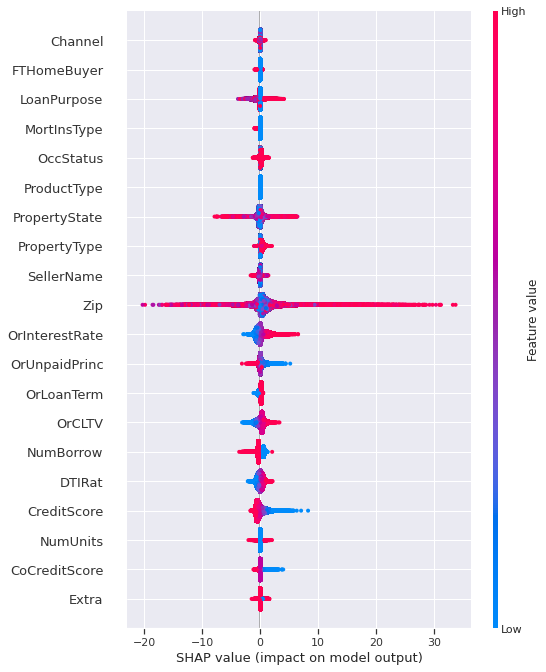

In [16]:
shap.summary_plot(svals, 
                  df[CATEGORICAL_COLUMNS+CONTINUOUS_COLUMNS].to_pandas(), sort=False, show=False)
plt.tight_layout()
f = plt.gcf()
a = plt.gca()
# a.set_xlim([-6, 6])
f.savefig(f'{figures_path}/GradShap_nvt_mlp_all_batches_noaxlim.png', dpi=600)

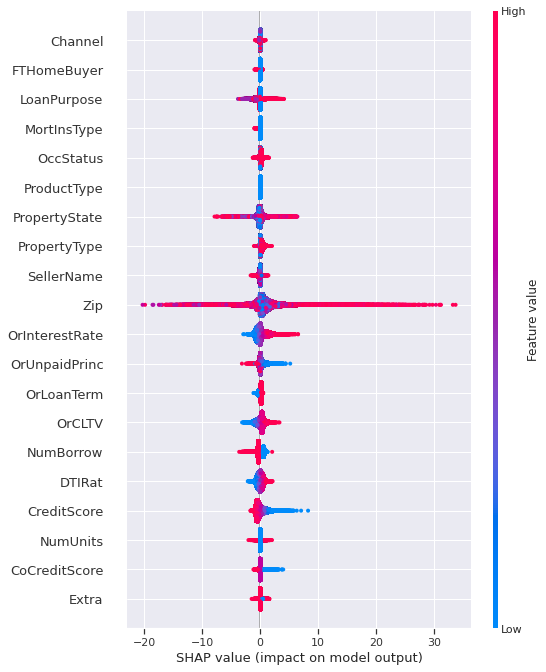

In [17]:
shap.summary_plot(svals, 
                  df[CATEGORICAL_COLUMNS+CONTINUOUS_COLUMNS].to_pandas(), sort=False, show=False)
plt.tight_layout()
f = plt.gcf()
a = plt.gca()
# a.set_xlim([-6, 6])
f.savefig(f'{figures_path}/GradShap_pyt_mlp_all_batches_noaxlim.png', dpi=600)

In [18]:
# uses ~ 28GB GPU memory
# to explore shap values of just positive or negative class adjust cells accordingly

attr_gs, delta = gradshap.attribute((torch.cat([pos_cats, neg_cats], dim=0), torch.cat([pos_conts, neg_conts], dim=0)),
                                        baselines=(torch.zeros_like(neg_cats, device=device), torch.zeros_like(neg_conts, device=device)),
                                        n_samples=200,
                                        return_convergence_delta=True)

11693

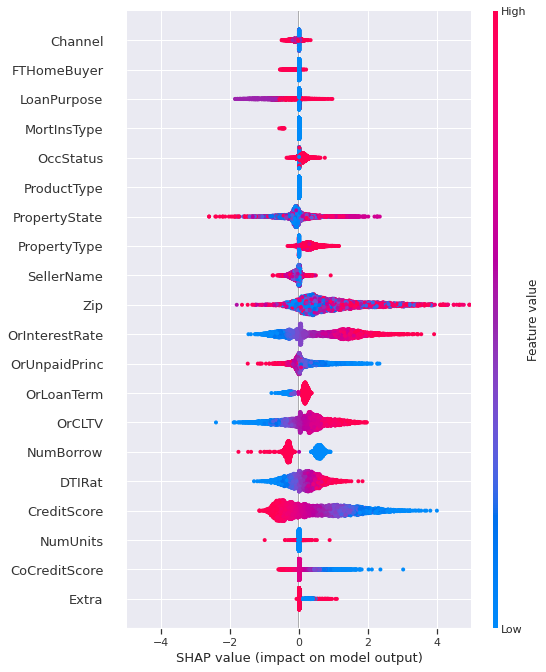

In [19]:

df = DataFrame(cp.asarray(torch.cat([torch.cat([pos_cats, pos_conts], dim=1), torch.cat([neg_cats, neg_conts], dim=1)], dim=0)))
df.columns = CATEGORICAL_COLUMNS +  CONTINUOUS_COLUMNS
svals = cp.asnumpy(torch.cat(attr_gs, dim=1))
shap.summary_plot(svals, 
                  df[CATEGORICAL_COLUMNS+CONTINUOUS_COLUMNS].to_pandas(), sort=False, show=False)
plt.tight_layout()
f = plt.gcf()
a = plt.gca()
a.set_xlim([-5, 5])
f.savefig(f'{figures_path}/GradShap_pyt_mlp.png', dpi=600)

del df, svals, attr_gs, delta; gc.collect()



In [20]:
def norm_attr_method(attr_method):
    method_sum = attr_method.sum(0)
    method_norm_sum = method_sum / np.linalg.norm(method_sum, ord=1)
    return method_norm_sum

def plot_importances(imps: list, feature_names, title, xaxis_title, yaxis_title, colors, legends, normalize_vectors=True, save=''):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title(title)
    ax.set_xlabel(xaxis_title)
    x_axis_data = np.arange(len(feature_names))
    width = 0.25
    wdth = 0
    for attr_meth, color, leg_label in zip(imps, colors, legends):
        if normalize_vectors:
            meth_norm_sum = norm_attr_method(attr_meth)
        else:
            meth_norm_sum = attr_meth
        ax.bar(x_axis_data +  wdth*width, meth_norm_sum, width, align='center', alpha=0.8, color=color)
        print(leg_label)
        for feat_name, value in zip(feature_names, meth_norm_sum):
            print(feat_name, ": ", '%.3f'%(value))
        wdth += 1
    plt.legend(legends, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    ax.set_xticks(x_axis_data)
    ax.set_xticklabels(feature_names, rotation=45)
    ax.set_ylabel(yaxis_title)

    ax.autoscale_view()
    plt.tight_layout()
    if isinstance(save, str) and save:
        plt.savefig(save, dpi=600)


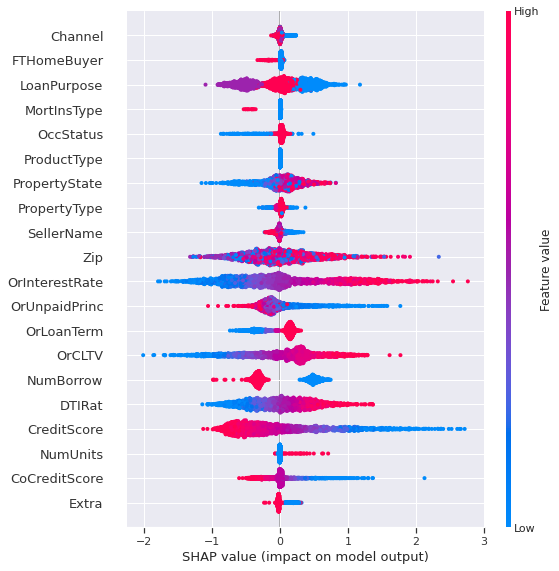

In [21]:

explainer = shap.GradientExplainer(model, [all_cats[:BATCH_SIZE], all_conts[:BATCH_SIZE]], batch_size=50)

shap_values = explainer.shap_values([all_cats[:BATCH_SIZE], all_conts[:BATCH_SIZE]])

df = DataFrame(cp.asarray(torch.cat([all_cats[:BATCH_SIZE], all_conts[:BATCH_SIZE]], dim=1)))
df.columns = CATEGORICAL_COLUMNS +  CONTINUOUS_COLUMNS

shap.summary_plot(np.concatenate( shap_values, axis=1), 
                  df[CATEGORICAL_COLUMNS+CONTINUOUS_COLUMNS].to_pandas(), sort=False, show=False)

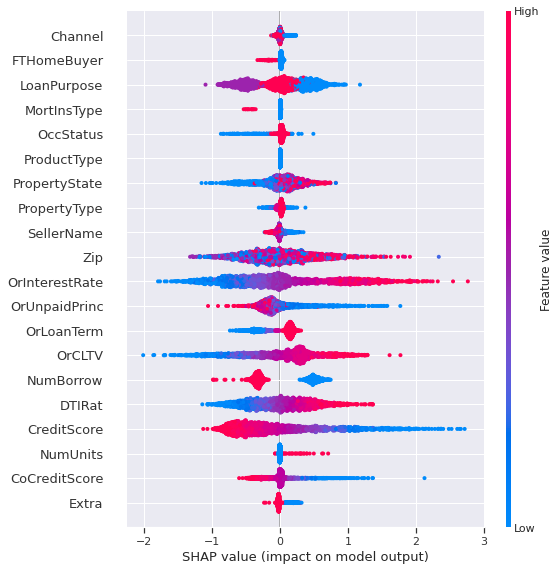

In [22]:
shap.summary_plot(np.concatenate( shap_values, axis=1), 
                  df[CATEGORICAL_COLUMNS+CONTINUOUS_COLUMNS].to_pandas(), sort=False, show=False)

In [23]:
# # Uncomment to run SHAP GradientExplainer with all_cats and all_conts - takes long time to run
# start = time.time()
# explainer = shap.GradientExplainer(model, [all_cats, all_conts], batch_size=50)

# shap_values = explainer.shap_values([all_cats, all_conts])
# print(f'Elapsed time: {time.time() - start: 0.3f} s')

# df = DataFrame(cp.asarray(torch.cat([all_cats, all_conts], dim=0)))
# df.columns = CATEGORICAL_COLUMNS +  CONTINUOUS_COLUMNS

# shap.summary_plot(np.concatenate( shap_values, axis=1), 
#                   df[CATEGORICAL_COLUMNS+CONTINUOUS_COLUMNS].to_pandas(), sort=False, show=False)

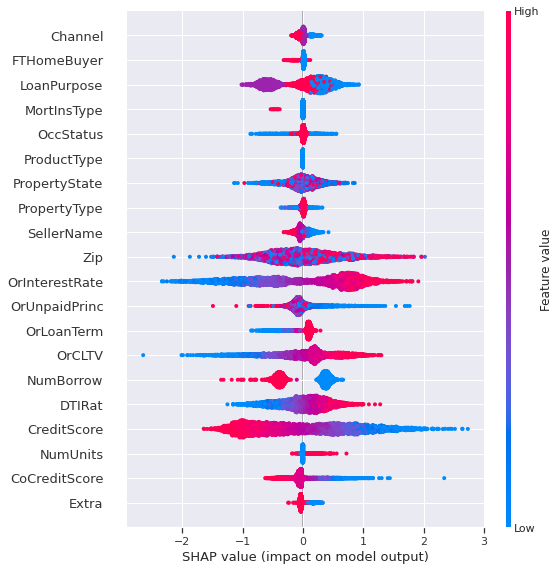

In [24]:
# Shap Gradient Explainer - https://github.com/slundberg/shap
explainer = shap.GradientExplainer(model, [torch.cat([pos_cats, neg_cats], dim=0), 
                                           torch.cat([pos_conts, neg_conts], dim=0)], 
                                   batch_size=512)

shap_values = explainer.shap_values([torch.cat([pos_cats, neg_cats], dim=0), 
                                           torch.cat([pos_conts, neg_conts], dim=0)])

df = DataFrame(cp.asarray(torch.cat([torch.cat([pos_cats, pos_conts], dim=1), 
                                     torch.cat([neg_cats, neg_conts], dim=1)], dim=0)))
df.columns = CATEGORICAL_COLUMNS +  CONTINUOUS_COLUMNS

shap.summary_plot(np.concatenate( shap_values, axis=1), 
                  df[CATEGORICAL_COLUMNS+CONTINUOUS_COLUMNS].to_pandas(), sort=False, show=False)

del df, shap_values, explainer

In [25]:
# apply integrated gradients by passing model to the IntegratedGradients object

ig = IntegratedGradients(model)

pos_attr, delta = ig.attribute((pos_cats, pos_conts), return_convergence_delta=True)
pos_attr_cat, pos_attr_cont = pos_attr[0].detach().cpu().numpy(), pos_attr[1].detach().cpu().numpy()

neg_attr, delta = ig.attribute((neg_cats, neg_conts), return_convergence_delta=True)
neg_attr_cat, neg_attr_cont = neg_attr[0].detach().cpu().numpy(), neg_attr[1].detach().cpu().numpy()

In [26]:
pos_attr_cat.shape

(2048, 10)

Default
Channel :  -0.051
FTHomeBuyer :  -0.010
LoanPurpose :  -0.142
MortInsType :  0.000
OccStatus :  0.033
ProductType :  0.000
PropertyState :  -0.040
PropertyType :  0.120
SellerName :  -0.039
Zip :  0.566
No Default
Channel :  -0.019
FTHomeBuyer :  -0.010
LoanPurpose :  -0.231
MortInsType :  -0.002
OccStatus :  0.073
ProductType :  0.000
PropertyState :  0.022
PropertyType :  0.163
SellerName :  -0.041
Zip :  0.439


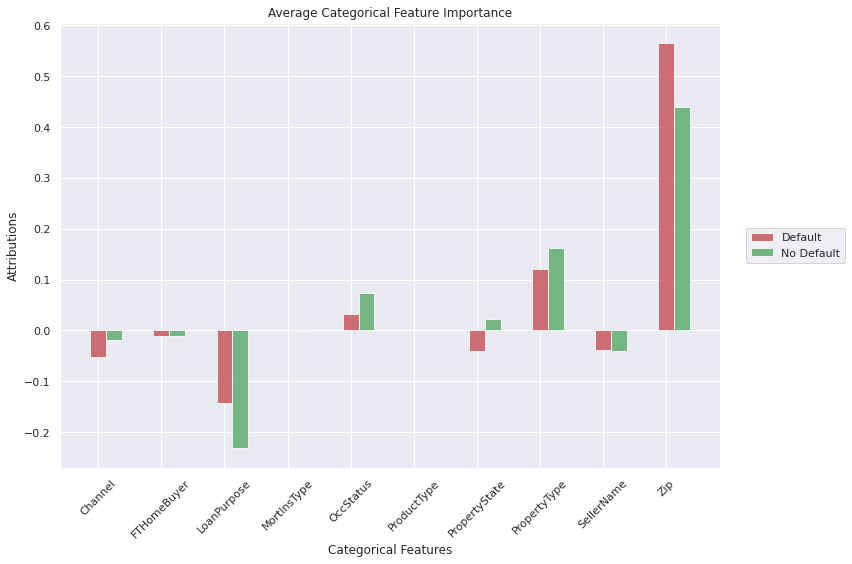

In [27]:

plot_importances([pos_attr_cat, neg_attr_cat], 
                 CATEGORICAL_COLUMNS, 
                 'Average Categorical Feature Importance',
                 'Categorical Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], save=f'{figures_path}/IG_cat_feats.png')

Default
OrInterestRate :  0.323
OrUnpaidPrinc :  0.046
OrLoanTerm :  0.041
OrCLTV :  0.111
NumBorrow :  0.063
DTIRat :  0.074
CreditScore :  0.268
NumUnits :  0.000
CoCreditScore :  0.050
Extra :  0.024
No Default
OrInterestRate :  0.223
OrUnpaidPrinc :  0.462
OrLoanTerm :  0.056
OrCLTV :  0.089
NumBorrow :  0.079
DTIRat :  0.017
CreditScore :  -0.008
NumUnits :  0.006
CoCreditScore :  -0.002
Extra :  0.057


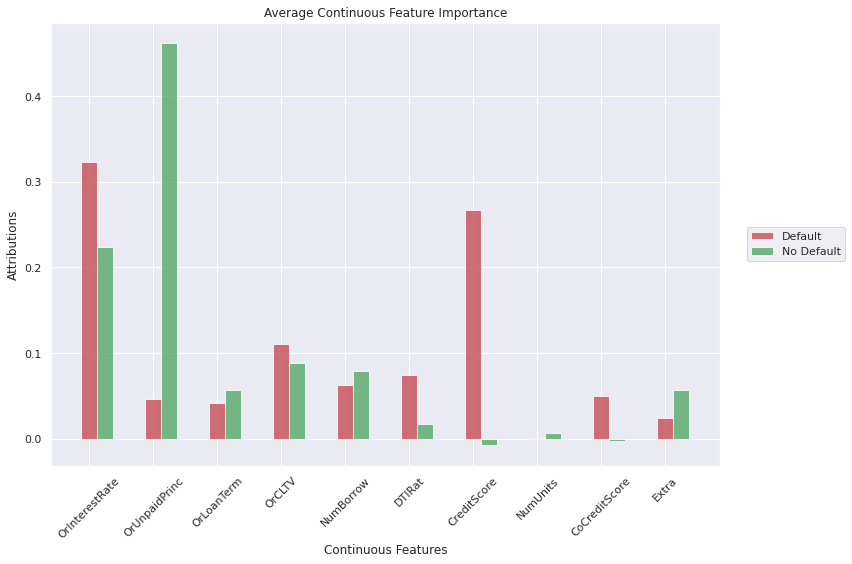

In [28]:
plot_importances([pos_attr_cont, neg_attr_cont], 
                 CONTINUOUS_COLUMNS, 
                 'Average Continuous Feature Importance',
                 'Continuous Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], save=f'{figures_path}/IG_cont_feats.png')

We still should explore attributions to ensure that mean/median attribution scores aren't from outliers i.e.

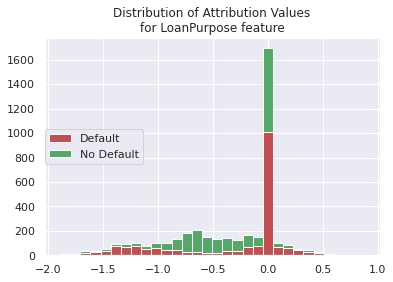

In [29]:
cat_colnum = 2
cat_col_name = CATEGORICAL_COLUMNS[cat_colnum]
plt.hist([pos_attr_cat[:, cat_colnum], neg_attr_cat[:, cat_colnum]], 30, color=['r', 'g'], stacked=True);
plt.title(f"Distribution of Attribution Values\nfor {cat_col_name} feature");
plt.legend(['Default', 'No Default'], loc="center left", borderaxespad=0)
plt.savefig(f'{figures_path}/IG_{cat_col_name}_feat_cat.png', dpi=600)

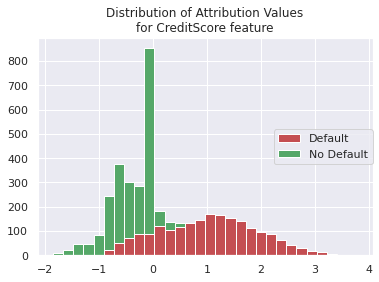

In [30]:
cont_colnum = -4
cont_col_name = CONTINUOUS_COLUMNS[cont_colnum]
plt.hist([pos_attr_cont[:, cont_colnum], neg_attr_cat[:, cat_colnum]], 30, color=['r','g'], stacked=True);
plt.title(f"Distribution of Attribution Values\nfor {cont_col_name} feature");
plt.legend(['Default', 'No Default'], loc="center right", borderaxespad=0)
plt.savefig(f'{figures_path}/IG_{cont_col_name}_feat_cat.png', dpi=600)

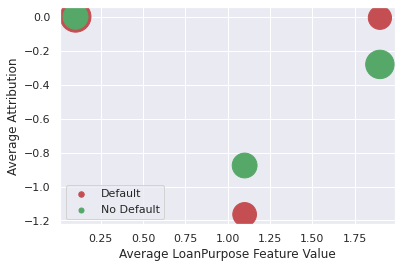

In [31]:
from scipy import stats

poscat_bin_means, poscat_bin_edges, _ = stats.binned_statistic(cp.asnumpy(pos_cats[:, cat_colnum]), pos_attr_cat[:, cat_colnum], 
                                                 statistic='mean', bins=10)
poscat_bin_count, _, _ = stats.binned_statistic(cp.asnumpy(pos_cats[:, cat_colnum]), pos_attr_cat[:, cat_colnum], 
                                         statistic='count', bins=10)

negcat_bin_means, negcat_bin_edges, _ = stats.binned_statistic(cp.asnumpy(neg_cats[:, cat_colnum]), neg_attr_cat[:, cat_colnum], 
                                                 statistic='mean', bins=10)
negcat_bin_count, _, _ = stats.binned_statistic(cp.asnumpy(neg_cats[:, cat_colnum]), neg_attr_cat[:, cat_colnum], 
                                         statistic='count', bins=10)

poscat_bin_width = (poscat_bin_edges[1] - poscat_bin_edges[0])
poscat_bin_centers = poscat_bin_edges[1:] - poscat_bin_width/2

negcat_bin_width = (negcat_bin_edges[1] - negcat_bin_edges[0])
negcat_bin_centers = negcat_bin_edges[1:] - negcat_bin_width/2

plt.scatter(poscat_bin_centers, poscat_bin_means, s=poscat_bin_count, color='r')
plt.scatter(negcat_bin_centers, negcat_bin_means, s=negcat_bin_count, color='g')

plt.xlabel(f"Average {cat_col_name} Feature Value");
plt.ylabel("Average Attribution");
plt.legend(['Default', 'No Default'], loc="lower left", markerscale=0.25)

plt.savefig(f'{figures_path}/IG_binned_{cat_col_name}_feat_cat.png', dpi=600)

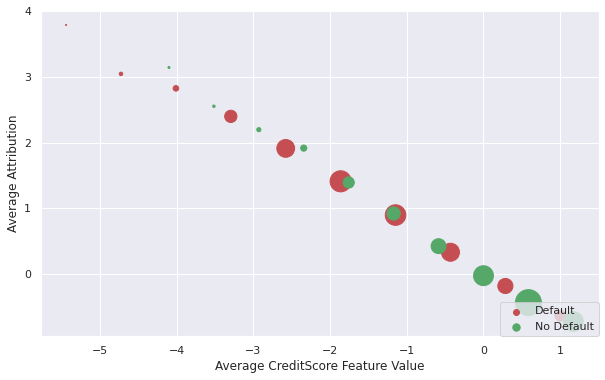

In [32]:
poscont_bin_means, poscont_bin_edges, _ = stats.binned_statistic(cp.asnumpy(pos_conts[:, cont_colnum]), pos_attr_cont[:, cont_colnum], 
                                                 statistic='mean', bins=10)
poscont_bin_count, _, _ = stats.binned_statistic(cp.asnumpy(pos_conts[:, cont_colnum]), pos_attr_cont[:, cont_colnum], 
                                         statistic='count', bins=10)

negcont_bin_means, negcont_bin_edges, _ = stats.binned_statistic(cp.asnumpy(neg_conts[:, cont_colnum]), neg_attr_cont[:, cont_colnum], 
                                                 statistic='mean', bins=10)
negcont_bin_count, _, _ = stats.binned_statistic(cp.asnumpy(neg_conts[:, cont_colnum]), neg_attr_cont[:, cont_colnum], 
                                         statistic='count', bins=10)

poscont_bin_width = (poscont_bin_edges[1] - poscont_bin_edges[0])
poscont_bin_centers = poscont_bin_edges[1:] - poscont_bin_width/2

negcont_bin_width = (negcont_bin_edges[1] - negcont_bin_edges[0])
negcont_bin_centers = negcont_bin_edges[1:] - negcont_bin_width/2

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(poscont_bin_centers, poscont_bin_means, s=poscont_bin_count, color='r')
ax.scatter(negcont_bin_centers, negcont_bin_means, s=negcont_bin_count, color='g')
ax.set_xlabel(f"Average {cont_col_name} Feature Value");
ax.set_ylabel("Average Attribution");
plt.legend(['Default', 'No Default'], loc="lower right", borderaxespad=0, markerscale=0.4)

plt.savefig(f'{figures_path}/IG_binned_{cont_col_name}_feat_cat.png', dpi=600)

 #### Layer conductance

In [33]:
cond = LayerConductance(model, model.layer_1)

In [34]:
pos_cond_vals = cond.attribute((pos_cats, pos_conts), target=0)
pos_cond_vals = pos_cond_vals.detach().cpu().numpy()

neg_cond_vals = cond.attribute((neg_cats, neg_conts), target=0)
neg_cond_vals = neg_cond_vals.detach().cpu().numpy()

In [35]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, print_values=False, title="Average Feature Importances",
                          axis_title="Features", color='b', save=''):
    print(title)
    if print_values:
        for i in range(len(feature_names)):
            print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    fig, ax = plt.subplots(figsize=(8,5))

    ax.bar(x_pos, importances, align='center', color=color)
#     plt.xticks(x_pos, feature_names, wrap=True, rotation=30)
    ax.set_xlabel(axis_title)
    ax.set_title(title)
    plt.xticks([])
    if isinstance(save, str) and save:
        plt.savefig(save, dpi=600)

In [36]:
# remove seaborn settings - https://stackoverflow.com/questions/26899310/python-seaborn-to-reset-back-to-the-matplotlib
import matplotlib
matplotlib.rc_file_defaults()


Default - Layer 1 Average Neuron Importances
No Default - Layer 1 Average Neuron Importances


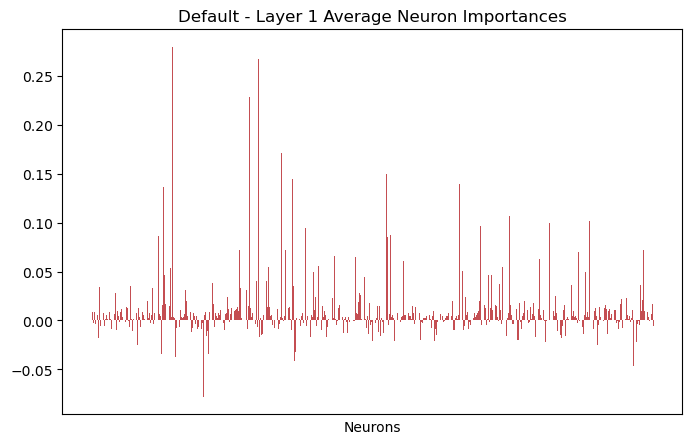

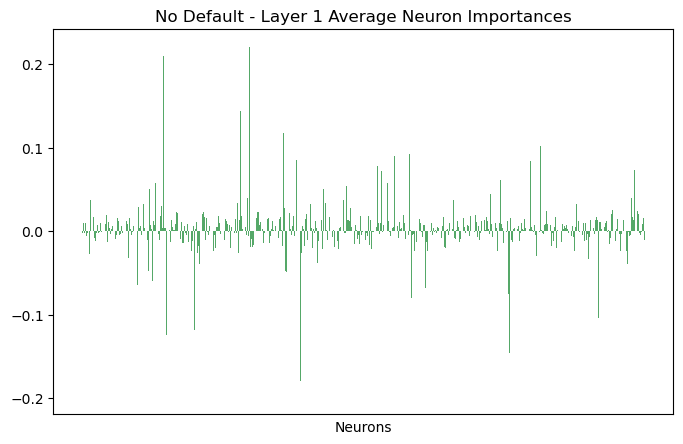

In [37]:
visualize_importances(range(512), np.mean(pos_cond_vals, axis=0),
                      print_values=False,
                      title="Default - Layer 1 Average Neuron Importances",
                      axis_title="Neurons",
                      color='r',
                      save=f'{figures_path}/LayerCond_layer1_default.png'
                     )
# plt.xticks([])
visualize_importances(range(512), np.mean(neg_cond_vals, axis=0),
                      print_values=False,
                      title="No Default - Layer 1 Average Neuron Importances",
                      axis_title="Neurons",
                      color='g',
                      save=f'{figures_path}/LayerCond_layer1_no_default.png'
                     )

# plt.xticks([])


In [38]:
# selecting some neurons for activation observation

# Notation here is: class__neuron_type
# ie. pos__pos_neuron is the positive class, and most positive mean neuron.

pos_mean_neuron = np.mean(pos_cond_vals, axis=0)
pos__not_learning= np.abs(pos_mean_neuron).argmin()
pos__pos_neuron = pos_mean_neuron.argmax()
pos__neg_neuron = pos_mean_neuron.argmin()

neg_mean_neuron = np.mean(neg_cond_vals, axis=0)
neg__not_learning= np.abs(neg_mean_neuron).argmin()
neg__pos_neuron = neg_mean_neuron.argmax()
neg__neg_neuron = neg_mean_neuron.argmin()

print('Positive Class: ', pos__not_learning, pos__pos_neuron, pos__neg_neuron)
print('Negative Class: ', neg__not_learning, neg__pos_neuron, neg__neg_neuron)

Positive Class:  366 74 102
Negative Class:  291 152 493


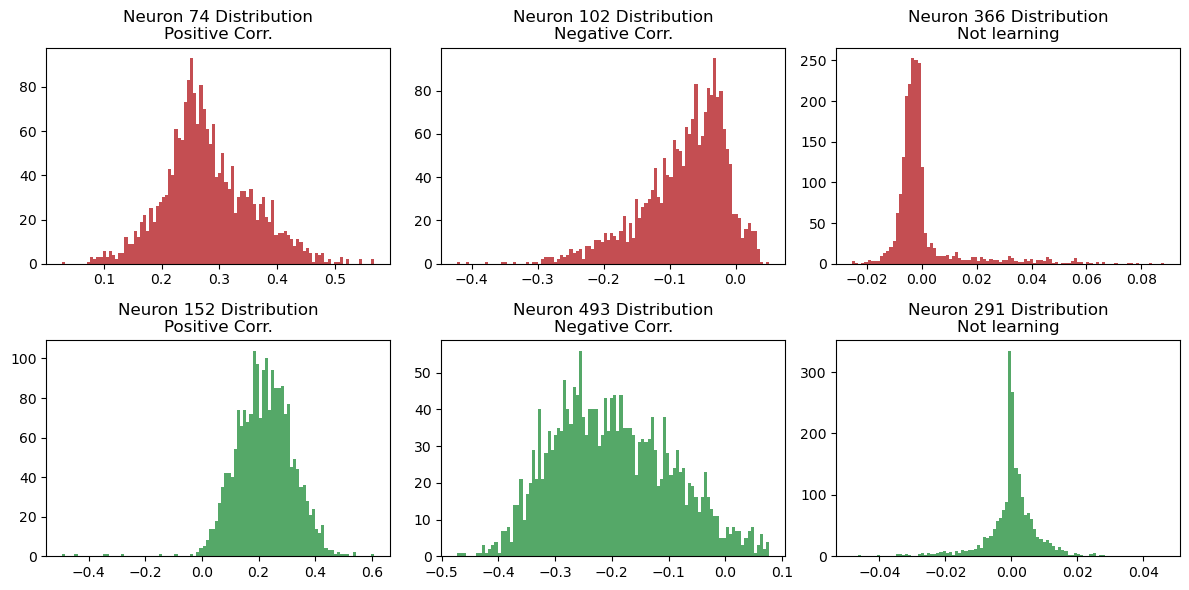

In [39]:
# these neurons are not learning much
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,6))


# positive correlation with default
ax[0, 0].hist(pos_cond_vals[:, pos__pos_neuron], 100, color='r');
ax[0, 0].set_title(f"Neuron {pos__pos_neuron} Distribution\nPositive Corr.")

ax[1, 0].hist(neg_cond_vals[:, neg__pos_neuron], 100, color='g');
ax[1, 0].set_title(f"Neuron {neg__pos_neuron} Distribution\nPositive Corr.")

# negative correlation with default
ax[0, 1].hist(pos_cond_vals[:, pos__neg_neuron], 100, color='r');
ax[0, 1].set_title(f"Neuron {pos__neg_neuron} Distribution\nNegative Corr.");

ax[1, 1].hist(neg_cond_vals[:, neg__neg_neuron], 100, color='g');
ax[1, 1].set_title(f"Neuron {neg__neg_neuron} Distribution\nNegative Corr.");

# no clear correlation with default
ax[0, 2].hist(pos_cond_vals[:, pos__not_learning], 100, color='r');
ax[0, 2].set_title(f"Neuron {pos__not_learning} Distribution\nNot learning")

ax[1, 2].hist(neg_cond_vals[:, neg__not_learning], 100, color='g');
ax[1, 2].set_title(f"Neuron {neg__not_learning} Distribution\nNot learning")

plt.tight_layout()
plt.savefig(f'{figures_path}/neuron_corr.png', dpi=600)

  ### Neuron attributions

In [40]:
# go back to seaborn styling
sns.set()
neuron_cond = NeuronConductance(model, model.layer_1)

In [41]:
# Notation: neuron_(class)_cond_vals_(neuron_type)

neuron_pos_cond_vals_pos = neuron_cond.attribute((pos_cats, pos_conts),
                                             neuron_selector=(pos__pos_neuron,), target=0)
neuron_pos_cond_vals_neg = neuron_cond.attribute((pos_cats, pos_conts),
                                             neuron_selector=(pos__neg_neuron,), target=0)
neuron_pos_cond_vals_notlearn = neuron_cond.attribute((pos_cats, pos_conts), 
                                             neuron_selector=(pos__not_learning,), target=0)

neuron_neg_cond_vals_pos = neuron_cond.attribute((neg_cats, neg_conts),
                                             neuron_selector=(neg__pos_neuron,), target=0)
neuron_neg_cond_vals_neg = neuron_cond.attribute((neg_cats, neg_conts),
                                             neuron_selector=(neg__neg_neuron,), target=0)
neuron_neg_cond_vals_notlearn = neuron_cond.attribute((neg_cats, neg_conts), 
                                             neuron_selector=(neg__not_learning,), target=0)


# swapping the class and neuron - neuron_selector
# i.e what is the negative/positive neuron (selected above) attribution for the positive/negative class
# this is so we can have comparison of the same node attributions for each class for each of the three cases.
neuron_pos_cond_vals_pos_swap = neuron_cond.attribute((pos_cats, pos_conts),
                                             neuron_selector=(neg__pos_neuron,), target=0)
neuron_pos_cond_vals_neg_swap = neuron_cond.attribute((pos_cats, pos_conts),
                                             neuron_selector=(neg__neg_neuron,), target=0)
neuron_pos_cond_vals_notlearn_swap = neuron_cond.attribute((pos_cats, pos_conts), 
                                             neuron_selector=(neg__not_learning,), target=0)

neuron_neg_cond_vals_pos_swap = neuron_cond.attribute((neg_cats, neg_conts),
                                             neuron_selector=(pos__pos_neuron,), target=0)
neuron_neg_cond_vals_neg_swap = neuron_cond.attribute((neg_cats, neg_conts),
                                             neuron_selector=(pos__neg_neuron,), target=0)
neuron_neg_cond_vals_notlearn_swap = neuron_cond.attribute((neg_cats, neg_conts), 
                                             neuron_selector=(pos__not_learning,), target=0)

In [42]:
neuron_pos_cond_vals_pos_cat, neuron_pos_cond_vals_pos_cont = neuron_pos_cond_vals_pos
neuron_pos_cond_vals_neg_cat, neuron_pos_cond_vals_neg_cont = neuron_pos_cond_vals_neg
neuron_pos_cond_vals_notlearn_cat, neuron_pos_cond_vals_notlearn_cont = neuron_pos_cond_vals_notlearn

neuron_neg_cond_vals_pos_cat, neuron_neg_cond_vals_pos_cont = neuron_neg_cond_vals_pos
neuron_neg_cond_vals_neg_cat, neuron_neg_cond_vals_neg_cont = neuron_neg_cond_vals_neg
neuron_neg_cond_vals_notlearn_cat, neuron_neg_cond_vals_notlearn_cont = neuron_neg_cond_vals_notlearn

# swap cases above
neuron_pos_cond_vals_pos_cat_swap, neuron_pos_cond_vals_pos_cont_swap = neuron_pos_cond_vals_pos_swap
neuron_pos_cond_vals_neg_cat_swap, neuron_pos_cond_vals_neg_cont_swap = neuron_pos_cond_vals_neg_swap
neuron_pos_cond_vals_notlearn_cat_swap, neuron_pos_cond_vals_notlearn_cont_swap = neuron_pos_cond_vals_notlearn_swap

neuron_neg_cond_vals_pos_cat_swap, neuron_neg_cond_vals_pos_cont_swap = neuron_neg_cond_vals_pos_swap
neuron_neg_cond_vals_neg_cat_swap, neuron_neg_cond_vals_neg_cont_swap = neuron_neg_cond_vals_neg_swap
neuron_neg_cond_vals_notlearn_cat_swap, neuron_neg_cond_vals_notlearn_cont_swap = neuron_neg_cond_vals_notlearn_swap

  #### Positve class - Default

Default
Channel :  0.001
FTHomeBuyer :  -0.002
LoanPurpose :  0.008
MortInsType :  0.000
OccStatus :  0.063
ProductType :  0.000
PropertyState :  0.012
PropertyType :  0.026
SellerName :  0.015
Zip :  0.057
No Default
Channel :  0.002
FTHomeBuyer :  -0.002
LoanPurpose :  0.012
MortInsType :  -0.000
OccStatus :  0.068
ProductType :  0.000
PropertyState :  0.013
PropertyType :  0.027
SellerName :  0.021
Zip :  0.065
Default
OrInterestRate :  0.075
OrUnpaidPrinc :  0.002
OrLoanTerm :  -0.006
OrCLTV :  0.008
NumBorrow :  0.001
DTIRat :  0.002
CreditScore :  0.005
NumUnits :  0.000
CoCreditScore :  0.005
Extra :  -0.000
No Default
OrInterestRate :  0.002
OrUnpaidPrinc :  -0.000
OrLoanTerm :  -0.000
OrCLTV :  -0.001
NumBorrow :  -0.000
DTIRat :  0.000
CreditScore :  -0.000
NumUnits :  0.000
CoCreditScore :  -0.000
Extra :  0.000


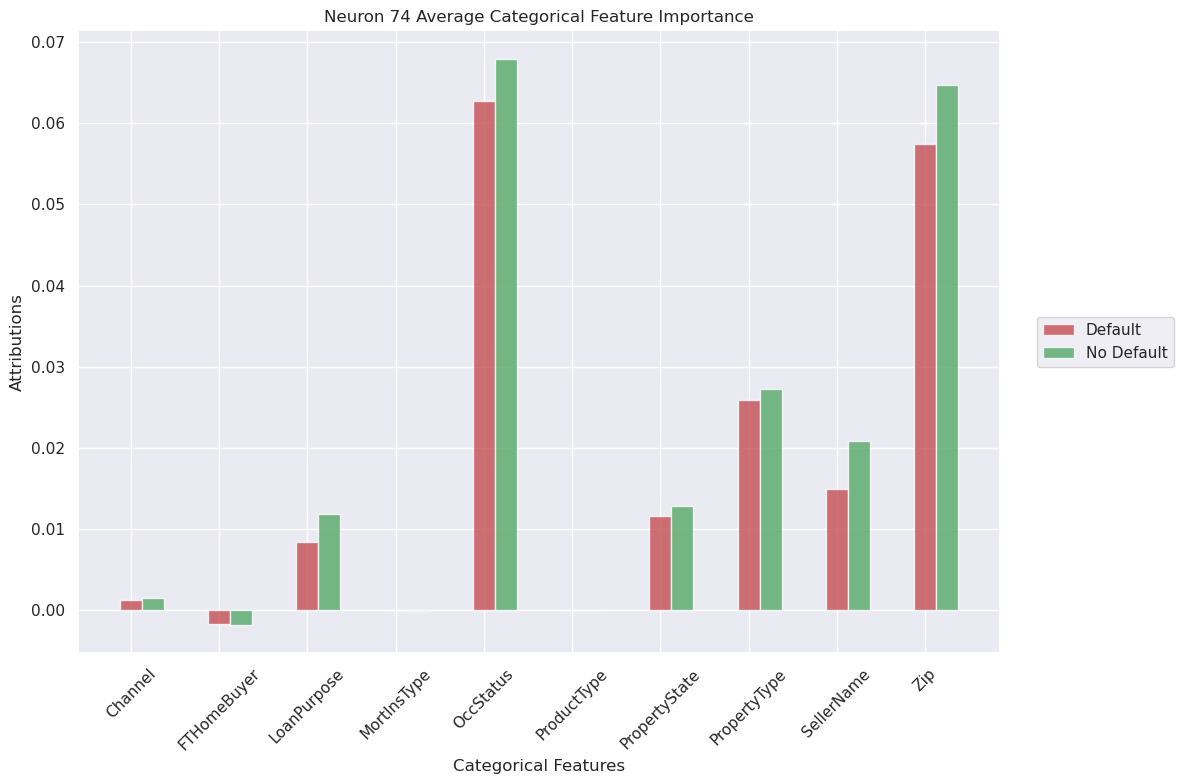

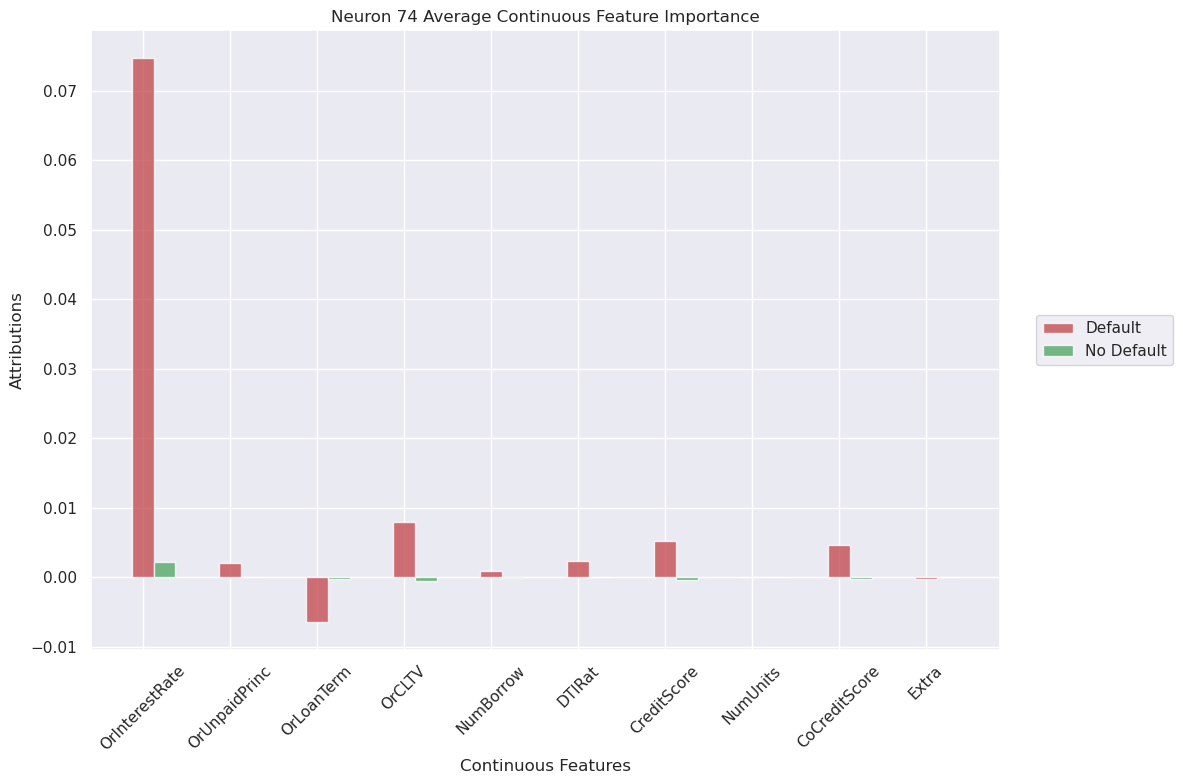

In [43]:
sns.set()
# the most positive neuron for the positive class - categorical(Default)
plot_importances([neuron_pos_cond_vals_pos_cat.mean(dim=0).detach().cpu().numpy(), 
                  neuron_neg_cond_vals_pos_cat_swap.mean(dim=0).detach().cpu().numpy()], 
                 CATEGORICAL_COLUMNS, 
                 f'Neuron {pos__pos_neuron} Average Categorical Feature Importance',
                 'Categorical Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False, 
                 save=f'{figures_path}/na_pos_pos_cat.png'
                )

# the most positive neuron for the positive class - continuous (Default)
plot_importances([neuron_pos_cond_vals_pos_cont.mean(dim=0).detach().cpu().numpy(), 
                  neuron_neg_cond_vals_pos_cont_swap.mean(dim=0).detach().cpu().numpy()], 
                 CONTINUOUS_COLUMNS, 
                 f'Neuron {pos__pos_neuron} Average Continuous Feature Importance',
                 'Continuous Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False, 
                save=f'{figures_path}/na_pos_pos_cont.png'
                )

Default
Channel :  -0.001
FTHomeBuyer :  0.001
LoanPurpose :  -0.021
MortInsType :  0.000
OccStatus :  -0.035
ProductType :  0.000
PropertyState :  -0.005
PropertyType :  -0.024
SellerName :  0.002
Zip :  -0.017
No Default
Channel :  -0.001
FTHomeBuyer :  0.001
LoanPurpose :  -0.027
MortInsType :  -0.000
OccStatus :  -0.040
ProductType :  0.000
PropertyState :  -0.006
PropertyType :  -0.026
SellerName :  0.002
Zip :  -0.019
Default
OrInterestRate :  0.011
OrUnpaidPrinc :  0.000
OrLoanTerm :  -0.001
OrCLTV :  -0.000
NumBorrow :  0.003
DTIRat :  0.002
CreditScore :  0.013
NumUnits :  -0.001
CoCreditScore :  -0.002
Extra :  -0.000
No Default
OrInterestRate :  0.001
OrUnpaidPrinc :  -0.000
OrLoanTerm :  -0.000
OrCLTV :  0.000
NumBorrow :  0.000
DTIRat :  -0.000
CreditScore :  -0.000
NumUnits :  -0.001
CoCreditScore :  0.000
Extra :  0.000


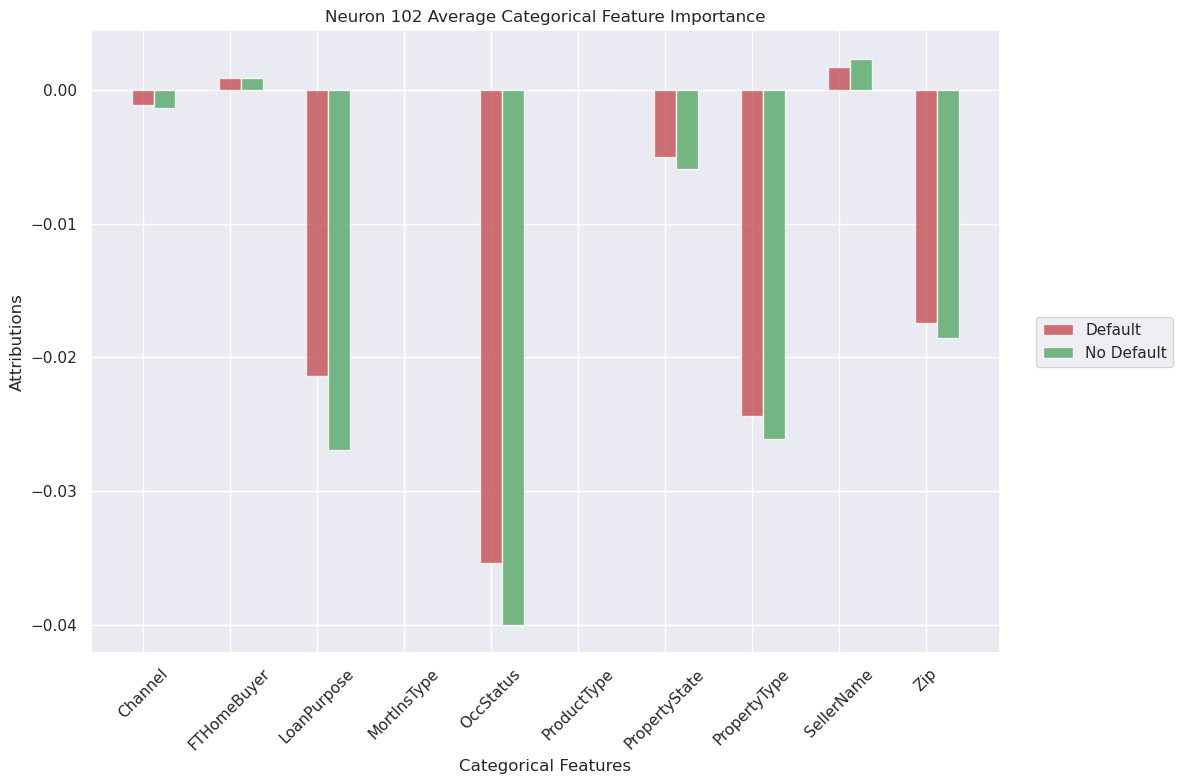

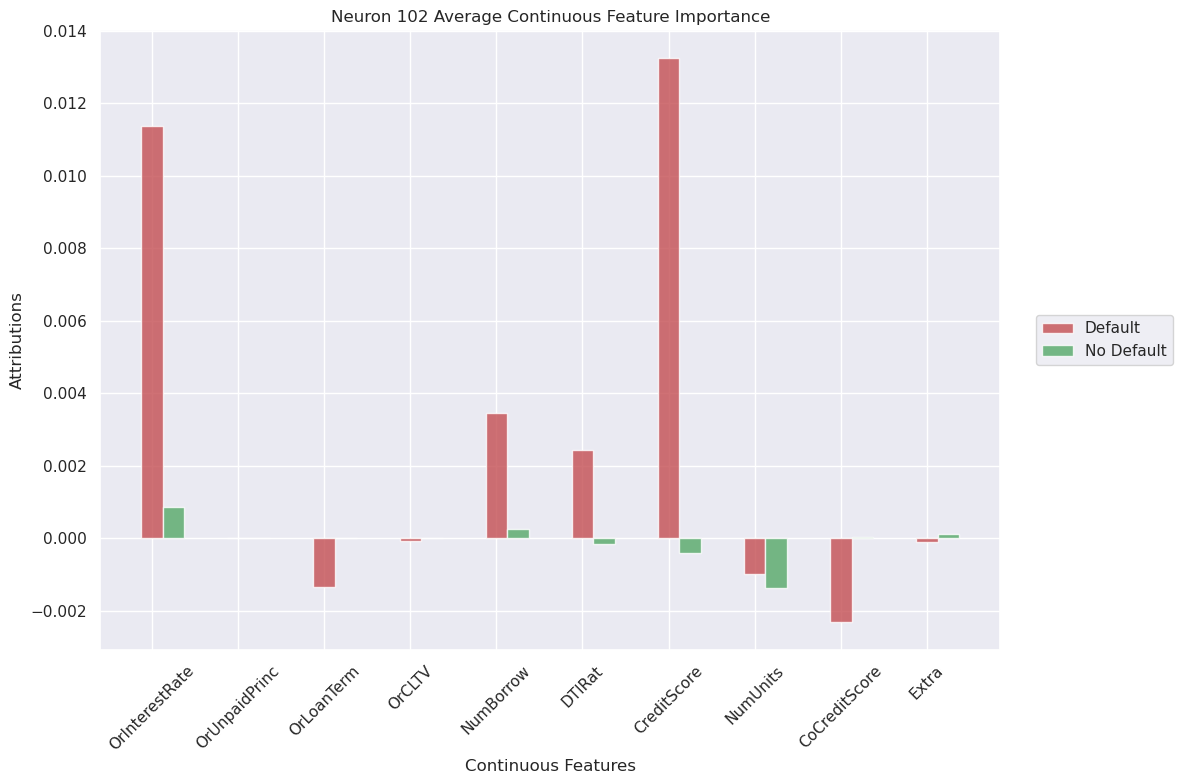

In [44]:
# the most negative neuron for the positive class - categorical(Default)
plot_importances([neuron_pos_cond_vals_neg_cat.mean(dim=0).detach().cpu().numpy(), 
                  neuron_neg_cond_vals_neg_cat_swap.mean(dim=0).detach().cpu().numpy()], 
                 CATEGORICAL_COLUMNS, 
                 f'Neuron {pos__neg_neuron} Average Categorical Feature Importance',
                 'Categorical Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False,
                 save=f'{figures_path}/na_pos_neg_cat.png'
                )

# the most negative neuron for the positive class - continuous (Default)
plot_importances([neuron_pos_cond_vals_neg_cont.mean(dim=0).detach().cpu().numpy(), 
                  neuron_neg_cond_vals_neg_cont_swap.mean(dim=0).detach().cpu().numpy()], 
                 CONTINUOUS_COLUMNS, 
                 f'Neuron {pos__neg_neuron} Average Continuous Feature Importance',
                 'Continuous Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False, 
                 save=f'{figures_path}/na_pos_neg_cont.png'
                )

Default
Channel :  0.000
FTHomeBuyer :  -0.000
LoanPurpose :  0.000
MortInsType :  0.000
OccStatus :  0.000
ProductType :  0.000
PropertyState :  0.004
PropertyType :  -0.000
SellerName :  0.004
Zip :  -0.008
No Default
Channel :  0.001
FTHomeBuyer :  -0.000
LoanPurpose :  0.000
MortInsType :  -0.000
OccStatus :  0.001
ProductType :  0.000
PropertyState :  0.007
PropertyType :  -0.000
SellerName :  0.008
Zip :  -0.015
Default
OrInterestRate :  -0.000
OrUnpaidPrinc :  0.000
OrLoanTerm :  0.000
OrCLTV :  0.000
NumBorrow :  -0.000
DTIRat :  0.000
CreditScore :  -0.000
NumUnits :  0.000
CoCreditScore :  0.000
Extra :  0.000
No Default
OrInterestRate :  0.000
OrUnpaidPrinc :  0.000
OrLoanTerm :  -0.000
OrCLTV :  -0.000
NumBorrow :  -0.000
DTIRat :  -0.000
CreditScore :  0.000
NumUnits :  0.000
CoCreditScore :  -0.000
Extra :  -0.000


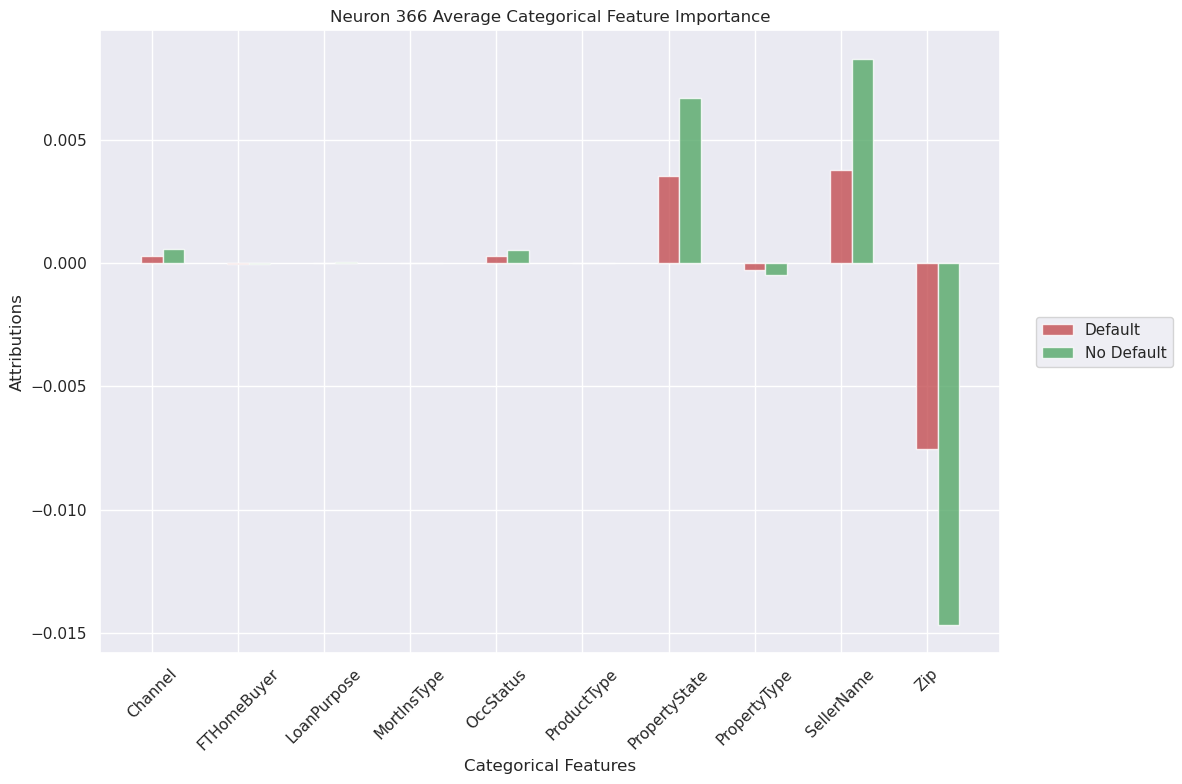

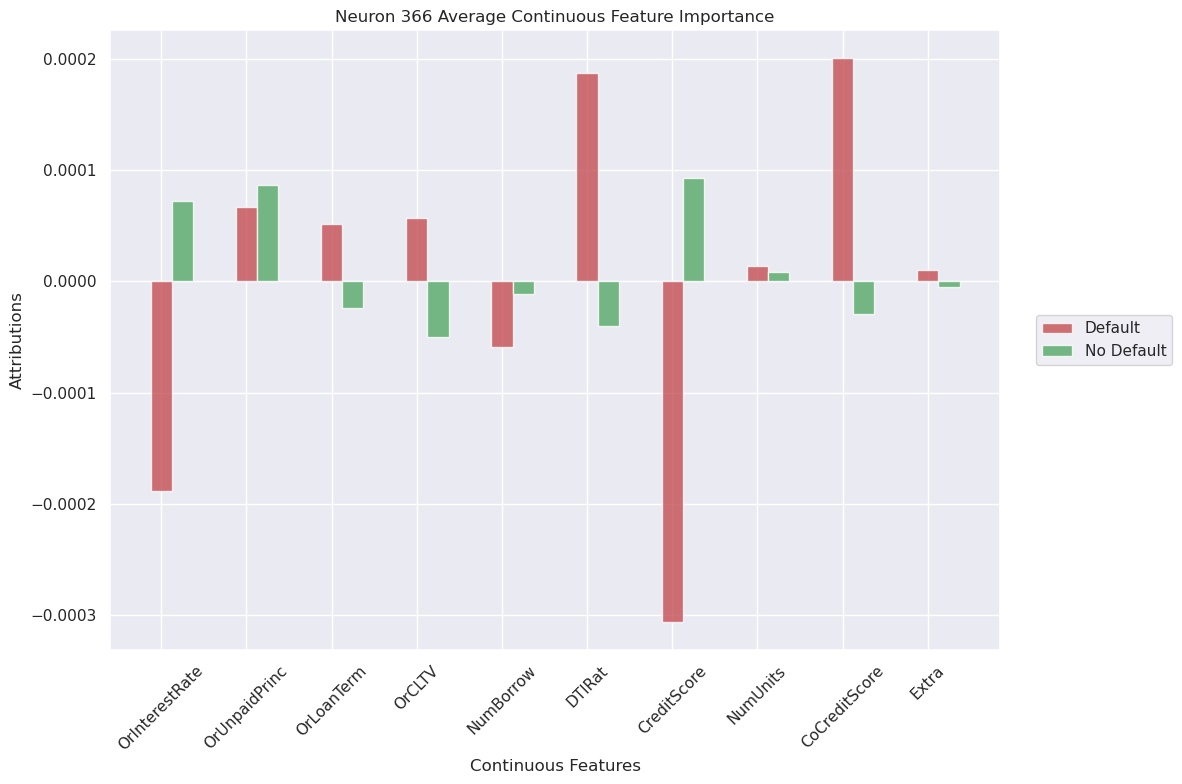

In [45]:
# the most not-learning neuron for the positive class - categorical(Default)
plot_importances([neuron_pos_cond_vals_notlearn_cat.mean(dim=0).detach().cpu().numpy(), 
                  neuron_neg_cond_vals_notlearn_cat_swap.mean(dim=0).detach().cpu().numpy()], 
                 CATEGORICAL_COLUMNS, 
                 f'Neuron {pos__not_learning} Average Categorical Feature Importance',
                 'Categorical Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False, 
                 save=f'{figures_path}/na_pos_notlearn_cat.png'
                )

# the most not-learning neuron for the positive class - continuous (Default)
plot_importances([neuron_pos_cond_vals_notlearn_cont.mean(dim=0).detach().cpu().numpy(), 
                  neuron_neg_cond_vals_notlearn_cont_swap.mean(dim=0).detach().cpu().numpy()], 
                 CONTINUOUS_COLUMNS, 
                 f'Neuron {pos__not_learning} Average Continuous Feature Importance',
                 'Continuous Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False,
                 save=f'{figures_path}/na_pos_notlearn_cont.png'
                )

 #### Negative Class - Not Default

Default
Channel :  0.031
FTHomeBuyer :  0.003
LoanPurpose :  -0.017
MortInsType :  -0.000
OccStatus :  0.027
ProductType :  0.000
PropertyState :  0.040
PropertyType :  0.060
SellerName :  0.049
Zip :  0.035
No Default
Channel :  0.021
FTHomeBuyer :  0.002
LoanPurpose :  -0.010
MortInsType :  0.000
OccStatus :  0.020
ProductType :  0.000
PropertyState :  0.030
PropertyType :  0.047
SellerName :  0.029
Zip :  0.026
Default
OrInterestRate :  -0.004
OrUnpaidPrinc :  0.002
OrLoanTerm :  0.000
OrCLTV :  -0.003
NumBorrow :  -0.002
DTIRat :  -0.000
CreditScore :  -0.003
NumUnits :  0.000
CoCreditScore :  -0.001
Extra :  0.000
No Default
OrInterestRate :  0.046
OrUnpaidPrinc :  -0.000
OrLoanTerm :  -0.008
OrCLTV :  0.013
NumBorrow :  0.006
DTIRat :  0.006
CreditScore :  0.021
NumUnits :  0.001
CoCreditScore :  0.011
Extra :  -0.000


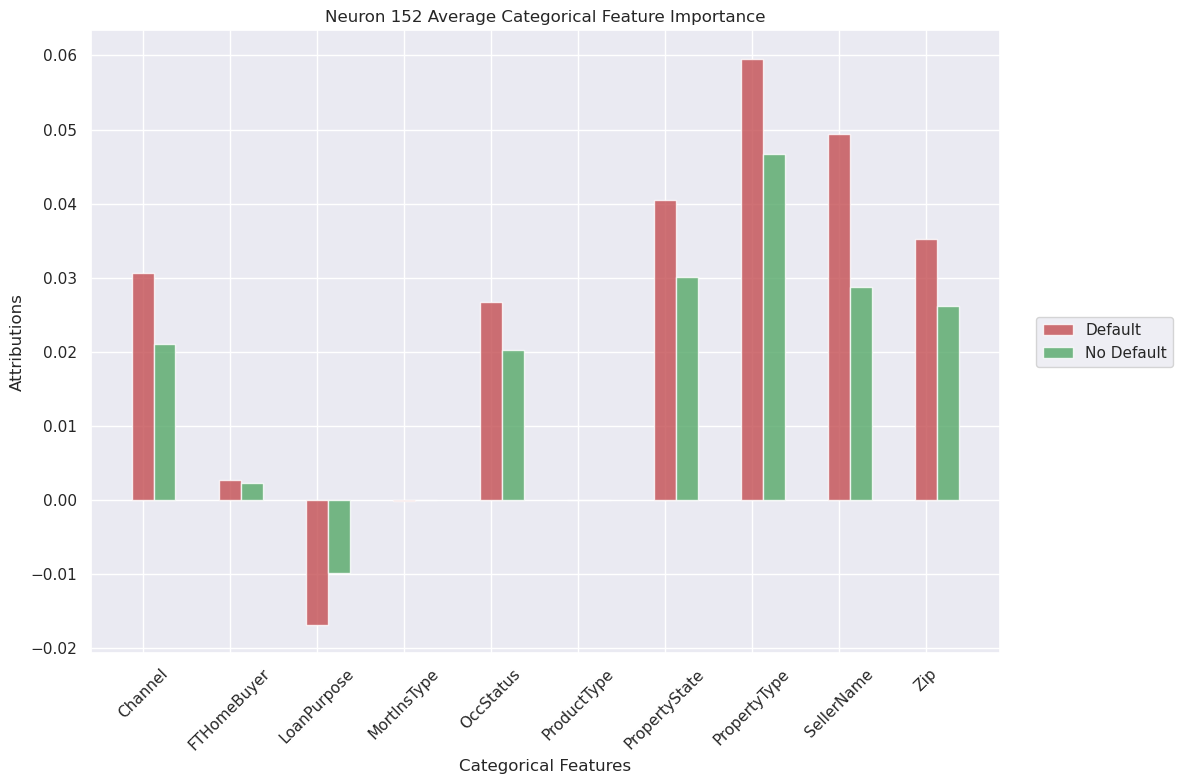

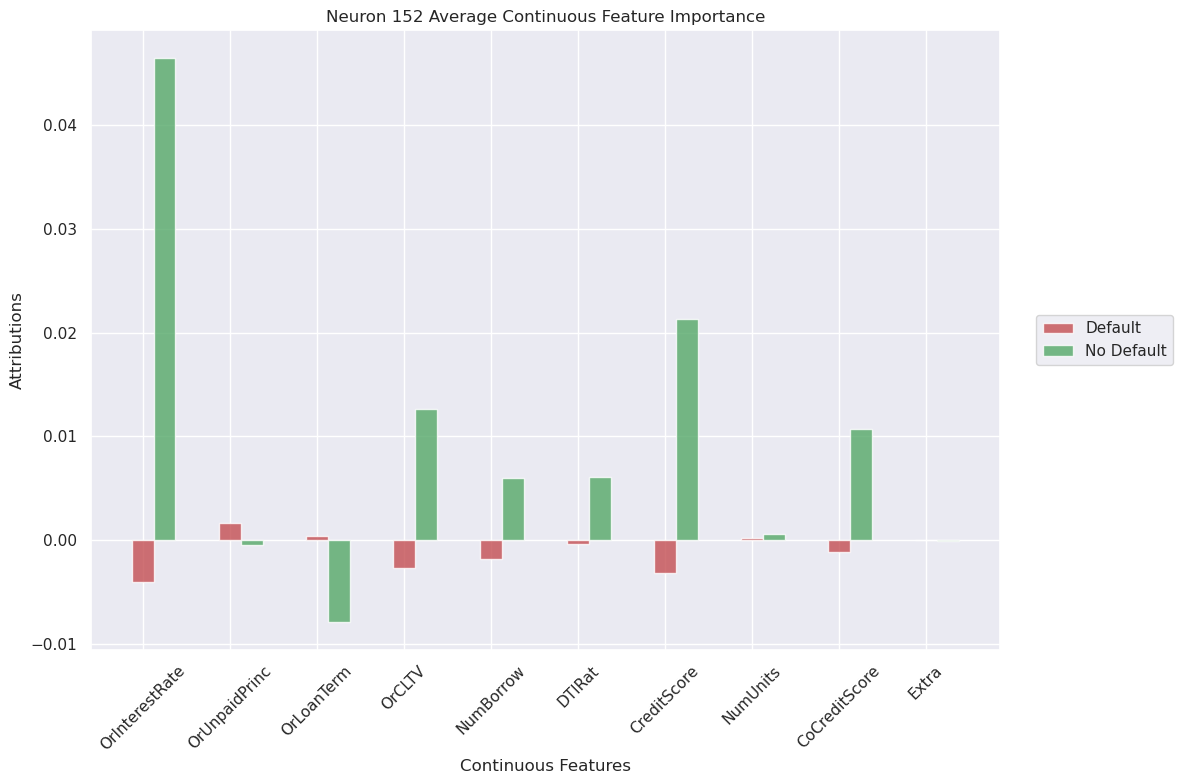

In [46]:

# the most positive neuron for the negative class - categorical(Default)
plot_importances([neuron_neg_cond_vals_pos_cat.mean(dim=0).detach().cpu().numpy(), 
                  neuron_pos_cond_vals_pos_cat_swap.mean(dim=0).detach().cpu().numpy()], 
                 CATEGORICAL_COLUMNS, 
                 f'Neuron {neg__pos_neuron} Average Categorical Feature Importance',
                 'Categorical Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False,
                 save=f'{figures_path}/na_neg_pos_cat.png'
                )

# the most positive neuron for the negative class - continuous (Default)
plot_importances([neuron_neg_cond_vals_pos_cont.mean(dim=0).detach().cpu().numpy(), 
                  neuron_pos_cond_vals_pos_cont_swap.mean(dim=0).detach().cpu().numpy()], 
                 CONTINUOUS_COLUMNS, 
                 f'Neuron {neg__pos_neuron} Average Continuous Feature Importance',
                 'Continuous Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False,
                 save=f'{figures_path}/na_neg_pos_cont.png'
                )

Default
Channel :  0.014
FTHomeBuyer :  -0.003
LoanPurpose :  -0.029
MortInsType :  -0.000
OccStatus :  -0.051
ProductType :  0.000
PropertyState :  -0.021
PropertyType :  -0.060
SellerName :  -0.007
Zip :  -0.030
No Default
Channel :  0.009
FTHomeBuyer :  -0.003
LoanPurpose :  -0.018
MortInsType :  0.000
OccStatus :  -0.038
ProductType :  0.000
PropertyState :  -0.015
PropertyType :  -0.046
SellerName :  -0.004
Zip :  -0.022
Default
OrInterestRate :  -0.003
OrUnpaidPrinc :  0.001
OrLoanTerm :  0.001
OrCLTV :  -0.001
NumBorrow :  -0.000
DTIRat :  -0.002
CreditScore :  -0.002
NumUnits :  0.000
CoCreditScore :  -0.000
Extra :  -0.000
No Default
OrInterestRate :  0.041
OrUnpaidPrinc :  0.004
OrLoanTerm :  -0.003
OrCLTV :  0.009
NumBorrow :  0.008
DTIRat :  0.010
CreditScore :  0.016
NumUnits :  -0.000
CoCreditScore :  0.005
Extra :  0.000


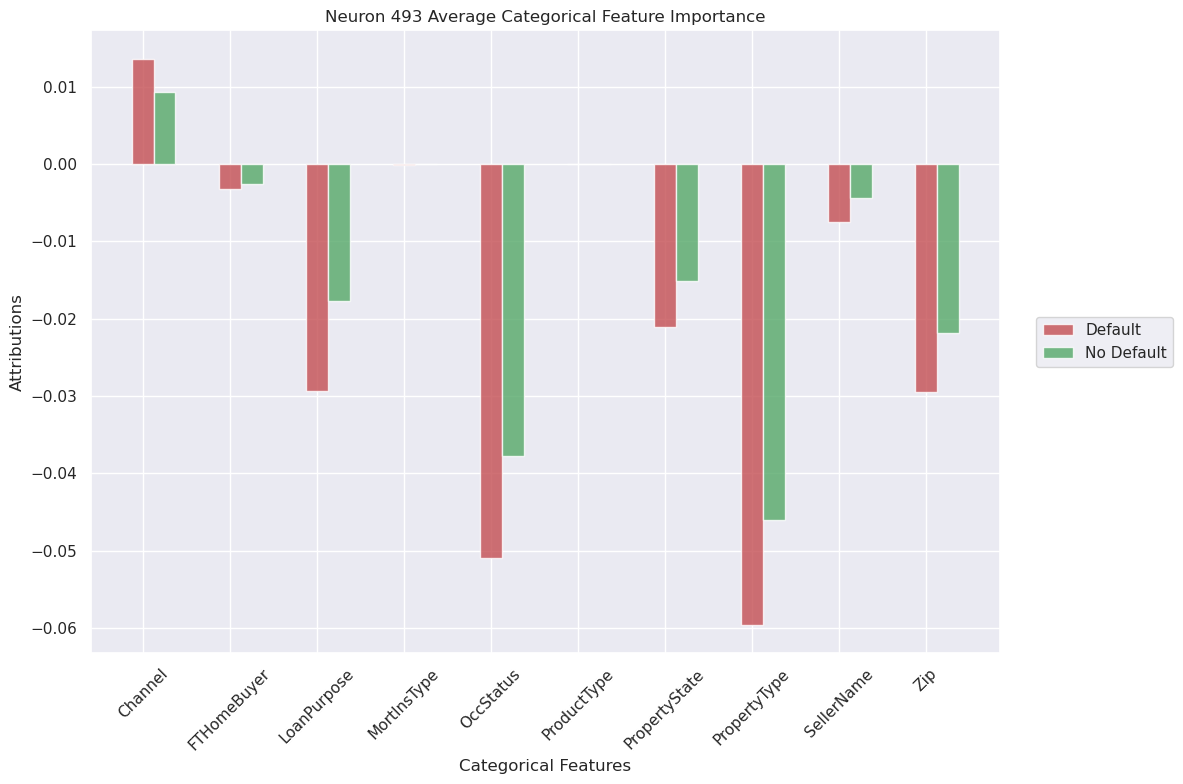

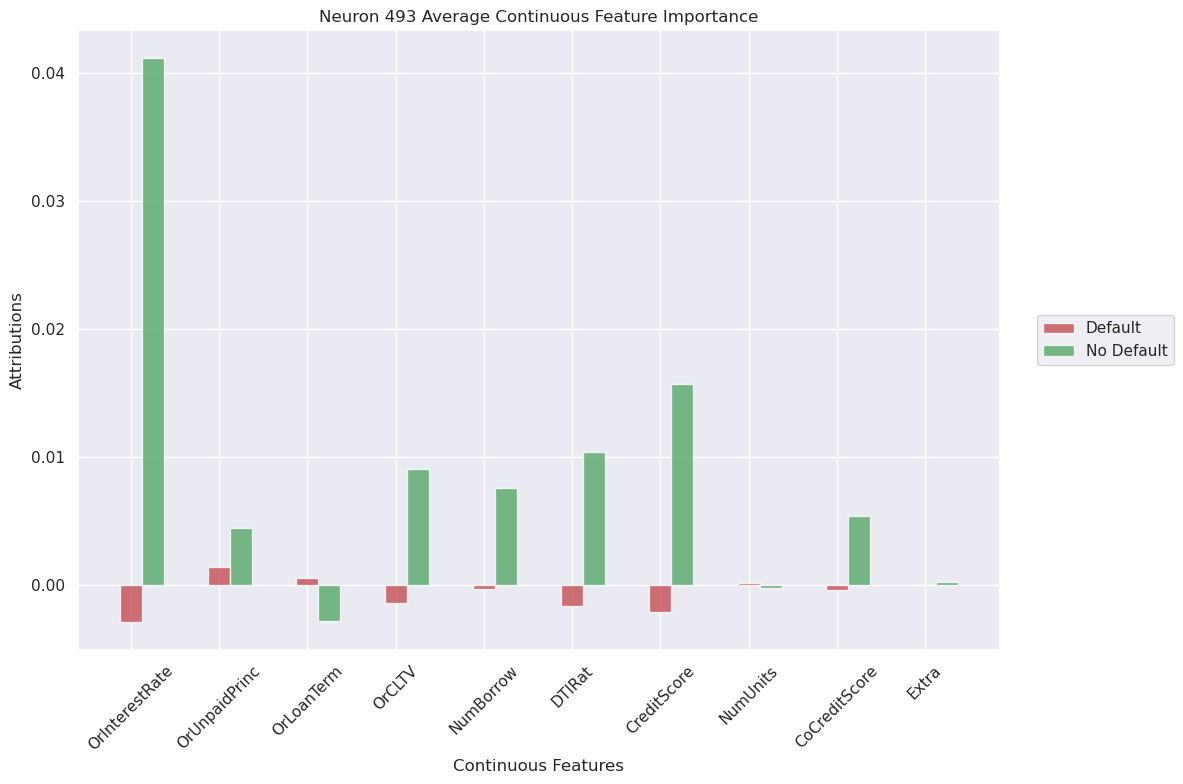

In [47]:

# the most negative neuron for the negative class - categorical(Default)
plot_importances([neuron_neg_cond_vals_neg_cat.mean(dim=0).detach().cpu().numpy(), 
                  neuron_pos_cond_vals_neg_cat_swap.mean(dim=0).detach().cpu().numpy()], 
                 CATEGORICAL_COLUMNS, 
                 f'Neuron {neg__neg_neuron} Average Categorical Feature Importance',
                 'Categorical Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False,
                 save=f'{figures_path}/na_neg_neg_cat.png'
                )

# the most negative neuron for the negative class - continuous (Default)
plot_importances([neuron_neg_cond_vals_neg_cont.mean(dim=0).detach().cpu().numpy(), 
                  neuron_pos_cond_vals_neg_cont_swap.mean(dim=0).detach().cpu().numpy()], 
                 CONTINUOUS_COLUMNS, 
                 f'Neuron {neg__neg_neuron} Average Continuous Feature Importance',
                 'Continuous Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False,
                 save=f'{figures_path}/na_neg_neg_cont.png'
                )

Default
Channel :  0.000
FTHomeBuyer :  -0.000
LoanPurpose :  0.000
MortInsType :  0.000
OccStatus :  -0.000
ProductType :  0.000
PropertyState :  0.001
PropertyType :  0.000
SellerName :  -0.000
Zip :  -0.001
No Default
Channel :  0.000
FTHomeBuyer :  -0.000
LoanPurpose :  -0.000
MortInsType :  0.000
OccStatus :  -0.000
ProductType :  0.000
PropertyState :  0.001
PropertyType :  0.000
SellerName :  -0.001
Zip :  0.001
Default
OrInterestRate :  0.000
OrUnpaidPrinc :  0.000
OrLoanTerm :  0.000
OrCLTV :  -0.000
NumBorrow :  -0.000
DTIRat :  -0.000
CreditScore :  -0.000
NumUnits :  0.000
CoCreditScore :  -0.000
Extra :  -0.000
No Default
OrInterestRate :  0.000
OrUnpaidPrinc :  0.000
OrLoanTerm :  -0.000
OrCLTV :  -0.000
NumBorrow :  -0.000
DTIRat :  0.000
CreditScore :  -0.000
NumUnits :  0.000
CoCreditScore :  -0.000
Extra :  -0.000


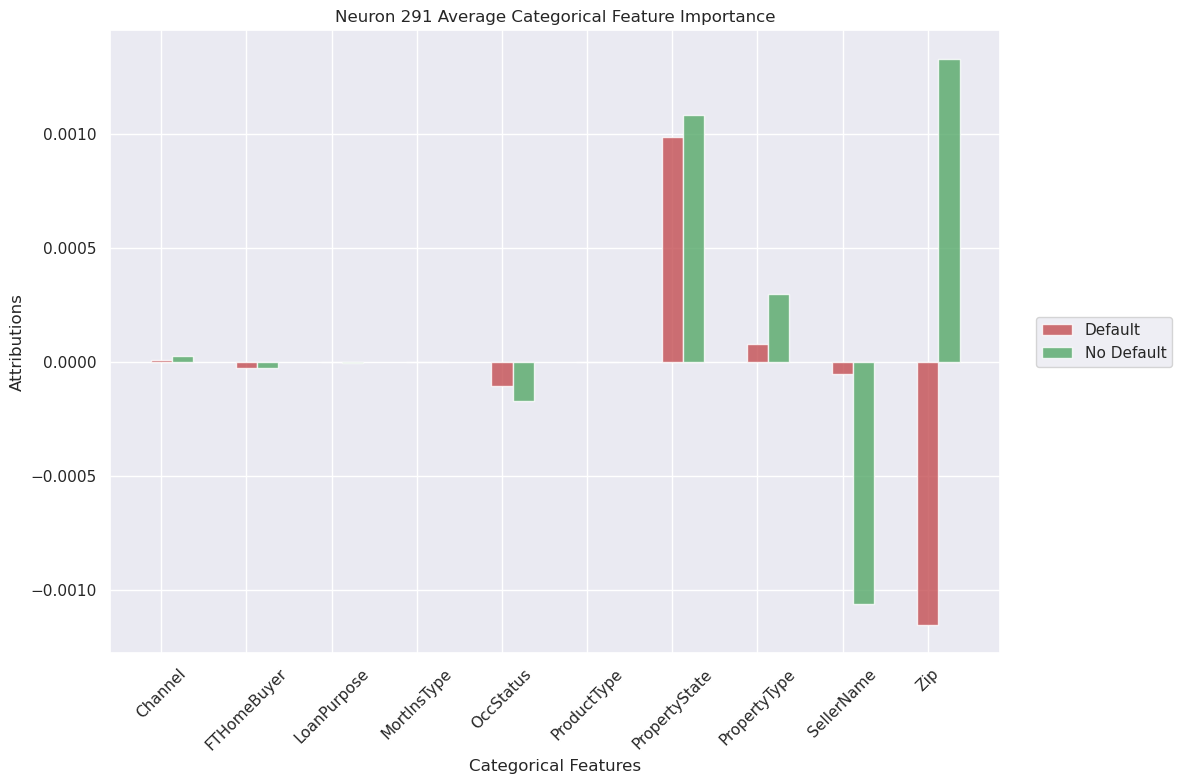

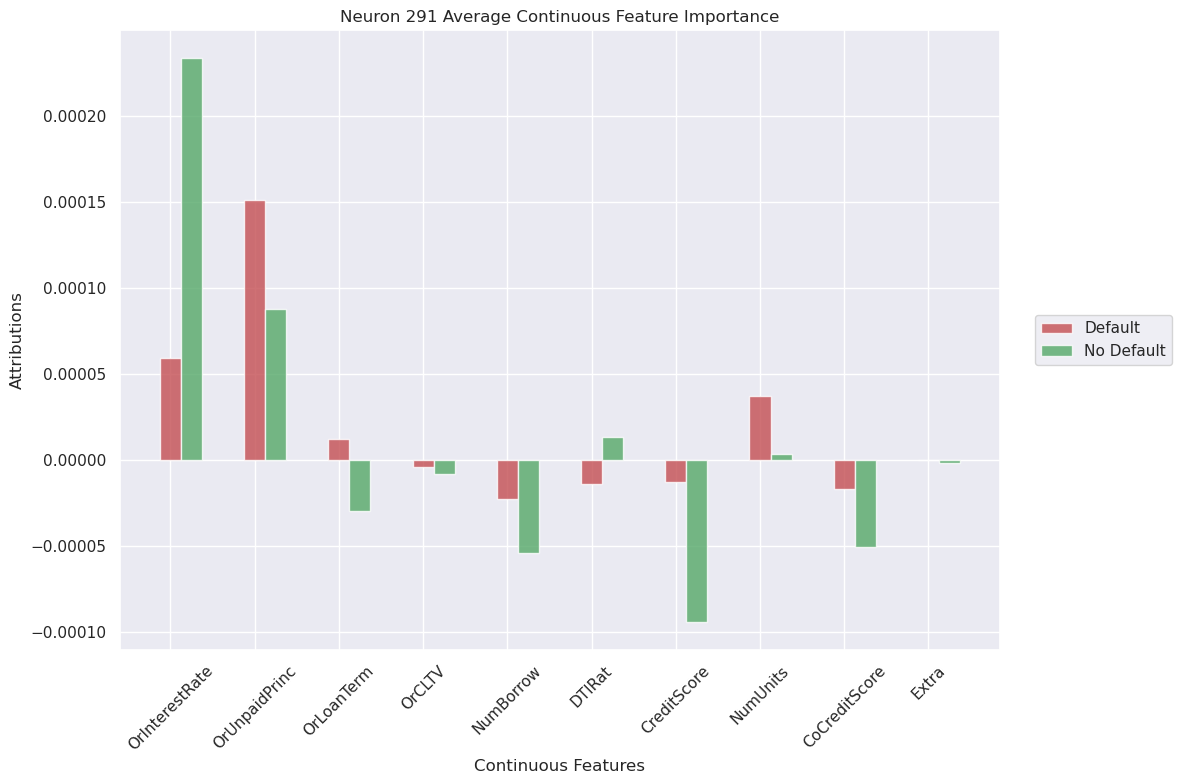

In [48]:
# the most not-learning neuron for the negative class - categorical(Default)
plot_importances([neuron_neg_cond_vals_notlearn_cat.mean(dim=0).detach().cpu().numpy(), 
                  neuron_pos_cond_vals_notlearn_cat_swap.mean(dim=0).detach().cpu().numpy()], 
                 CATEGORICAL_COLUMNS, 
                 f'Neuron {neg__not_learning} Average Categorical Feature Importance',
                 'Categorical Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False, 
                 save=f'{figures_path}/na_neg_notlearn_cat.png'
                )

# the most not-learning neuron for the negative class - continuous (Default)
plot_importances([neuron_neg_cond_vals_notlearn_cont.mean(dim=0).detach().cpu().numpy(), 
                  neuron_pos_cond_vals_notlearn_cont_swap.mean(dim=0).detach().cpu().numpy()], 
                 CONTINUOUS_COLUMNS, 
                 f'Neuron {neg__not_learning} Average Continuous Feature Importance',
                 'Continuous Features',
                 'Attributions',
                 ['r', 'g'], 
                 ['Default', 'No Default'], normalize_vectors=False,
                 save=f'{figures_path}/na_neg_notlearn_cont.png'
                )

 ### Compare across multiple algorithms and weights

In [49]:
# https://captum.ai/tutorials/House_Prices_Regression_Interpret
from captum.attr import IntegratedGradients, FeatureAblation

ig = IntegratedGradients(model)
fa = FeatureAblation(model)

In [50]:
def norm_attr_method(attr_method):
    method_sum = attr_method.detach().cpu().numpy().sum(0)
    method_norm_sum = method_sum / np.linalg.norm(method_sum, ord=1)
    return method_norm_sum

def plot_attributions(layer, layer_bounds, input_tensor, column_names, attr_methods, legends, colors, save=''):
    assert isinstance(layer_bounds, (tuple, list)) and len(layer_bounds) == 2
    
    lin_weight = layer.weight[0].detach().cpu().numpy()
    y_axis_lin_weight = (lin_weight / np.linalg.norm(lin_weight, ord=1))[layer_bounds[0]:layer_bounds[1]]

    x_axis_data = np.arange(input_tensor.shape[1])
    x_axis_data_labels = column_names
    
    # plotting
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
    ax.set_ylabel('Attributions')
    FONT_SIZE = 16
    width = 0.14
    plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
    plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
    plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
    plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend
    wdth = 0
    for attr_meth, color in zip(attr_methods, colors):
        meth_norm_sum = norm_attr_method(attr_meth)
        ax.bar(x_axis_data + wdth*width, meth_norm_sum, width, align='center', alpha=0.8, color=color)
        wdth += 1
    ax.bar(x_axis_data + (wdth+1)*width, y_axis_lin_weight, width, align='center', alpha=0.8, color='grey')
    
    ax.autoscale_view()
    ax.set_xticks(x_axis_data + 0.5)
    ax.set_xticklabels(x_axis_data_labels, rotation=45)

    plt.legend(legends, loc=3)
    plt.tight_layout()
    if isinstance(save, str) and save:
        plt.savefig(save, dpi=600)

In [51]:
ig_attr_pos_cat, ig_attr_pos_cont = ig.attribute((pos_cats, pos_conts), n_steps=50)
fa_attr_pos_cat, fa_attr_pos_cont = fa.attribute((pos_cats, pos_conts))

ig_attr_neg_cat, ig_attr_neg_cont = ig.attribute((neg_cats, neg_conts), n_steps=50)
fa_attr_neg_cat, fa_attr_neg_cont = fa.attribute((neg_cats, neg_conts))

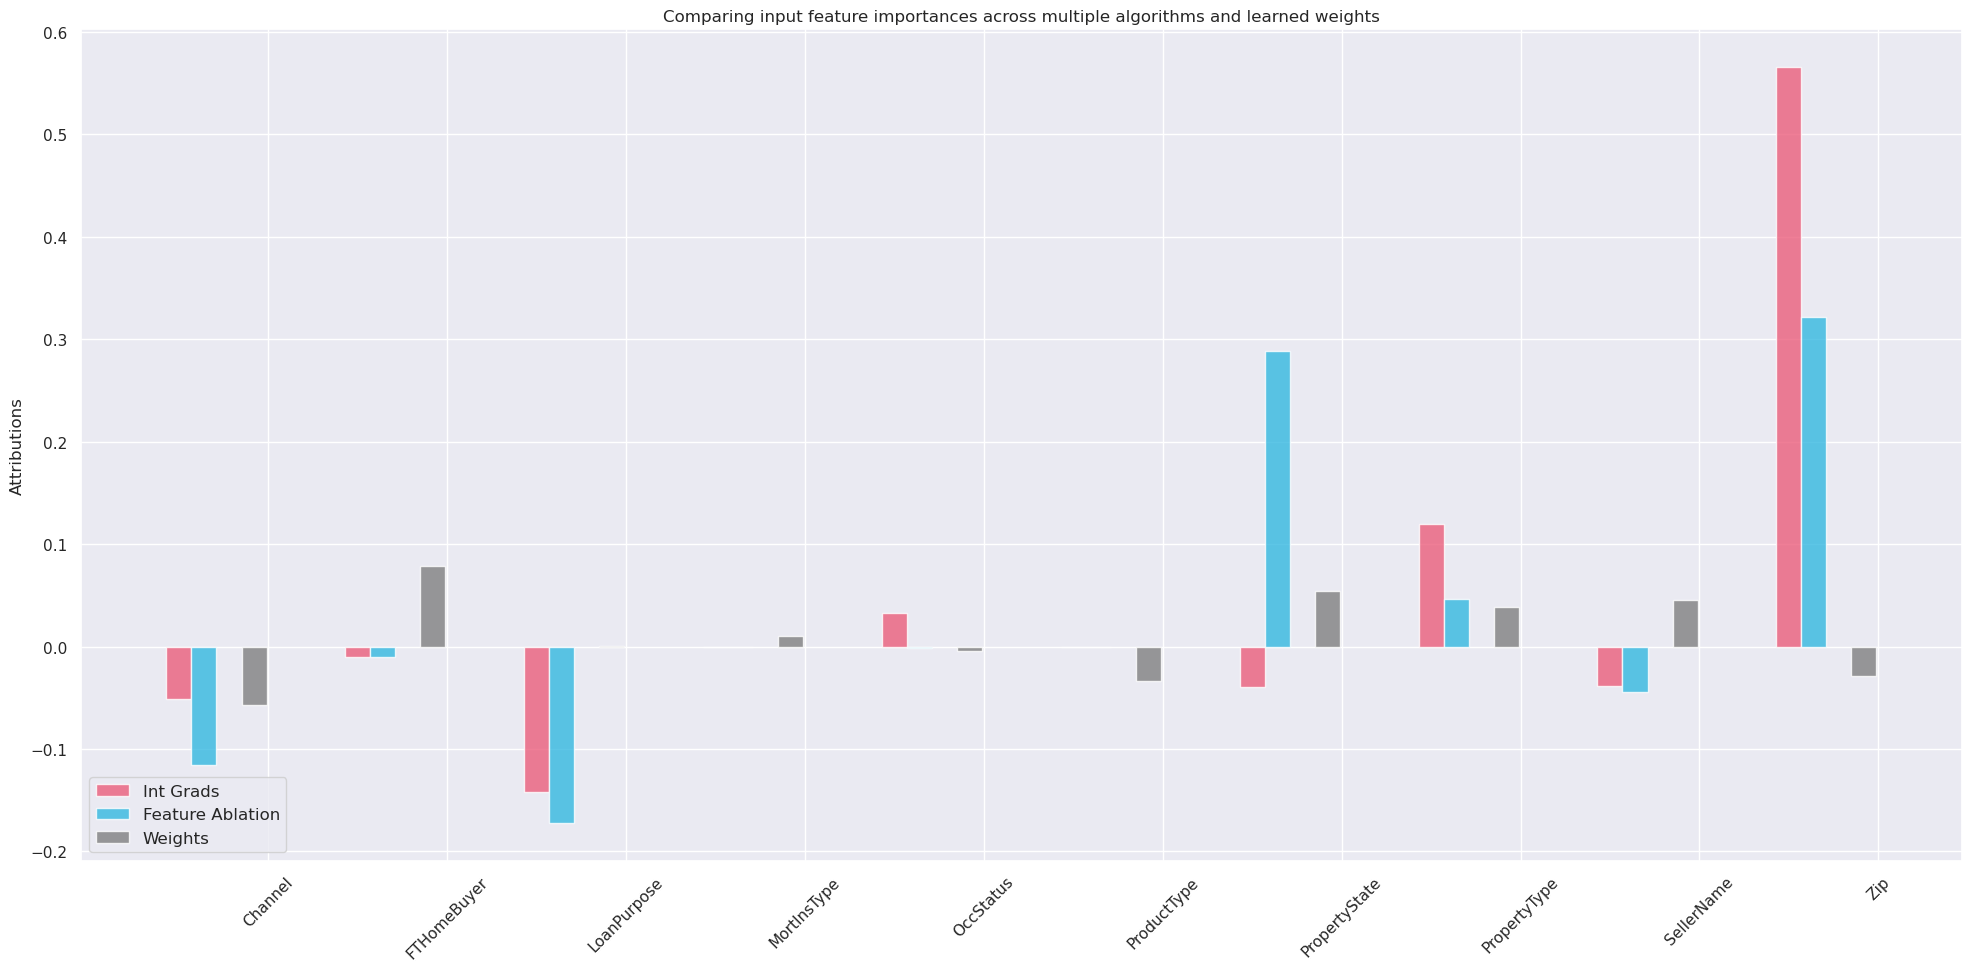

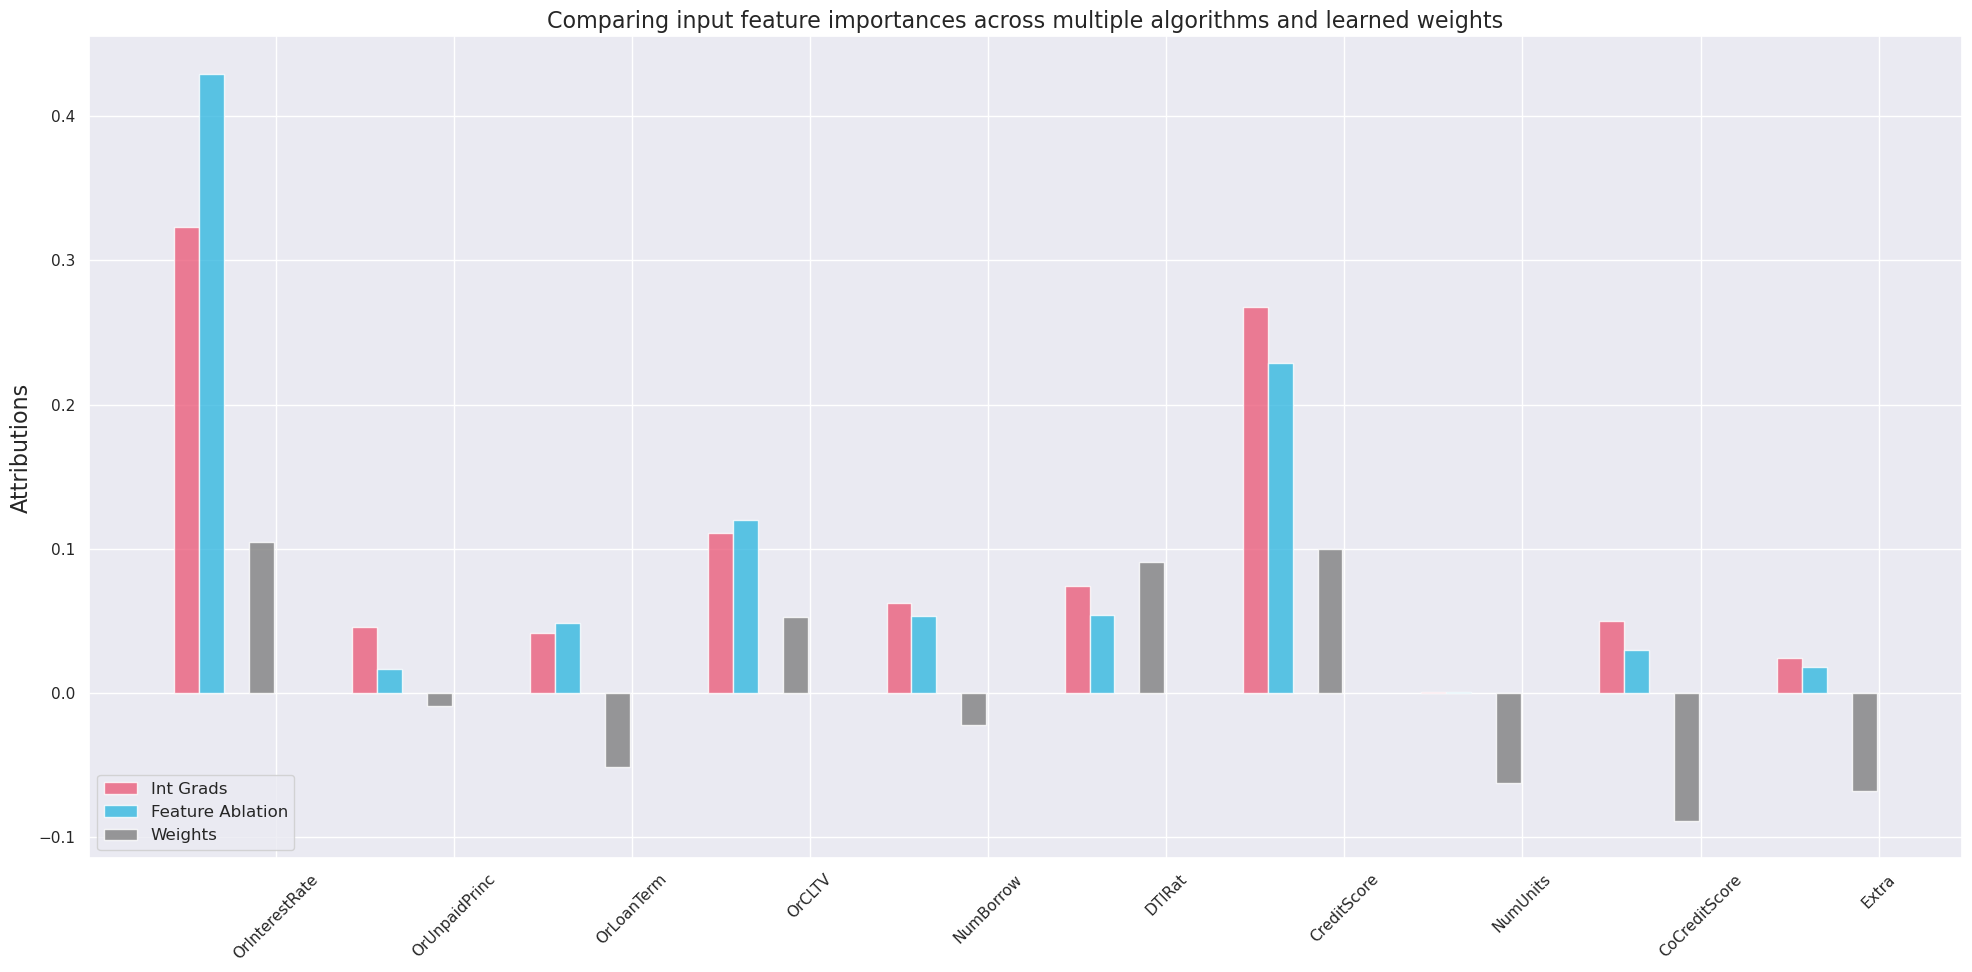

In [52]:
legends = ['Int Grads', 'Feature Ablation', 'Weights']
pos_attr_methds_cat = [ig_attr_pos_cat, fa_attr_pos_cat]
pos_attr_methd_cont = [ig_attr_pos_cont, fa_attr_pos_cont]
colors = ['#eb5e7c', '#34b8e0']

# Positive Class
plot_attributions(model.layer_1, (0, 10), pos_cats, CATEGORICAL_COLUMNS, 
                  pos_attr_methds_cat, legends, colors, save=f'{figures_path}/compare_cat_pos_class.png')
plot_attributions(model.layer_1, (10, 20), pos_conts, CONTINUOUS_COLUMNS, 
                  pos_attr_methd_cont, legends, colors, save=f'{figures_path}/compare_cont_pos_class.png')

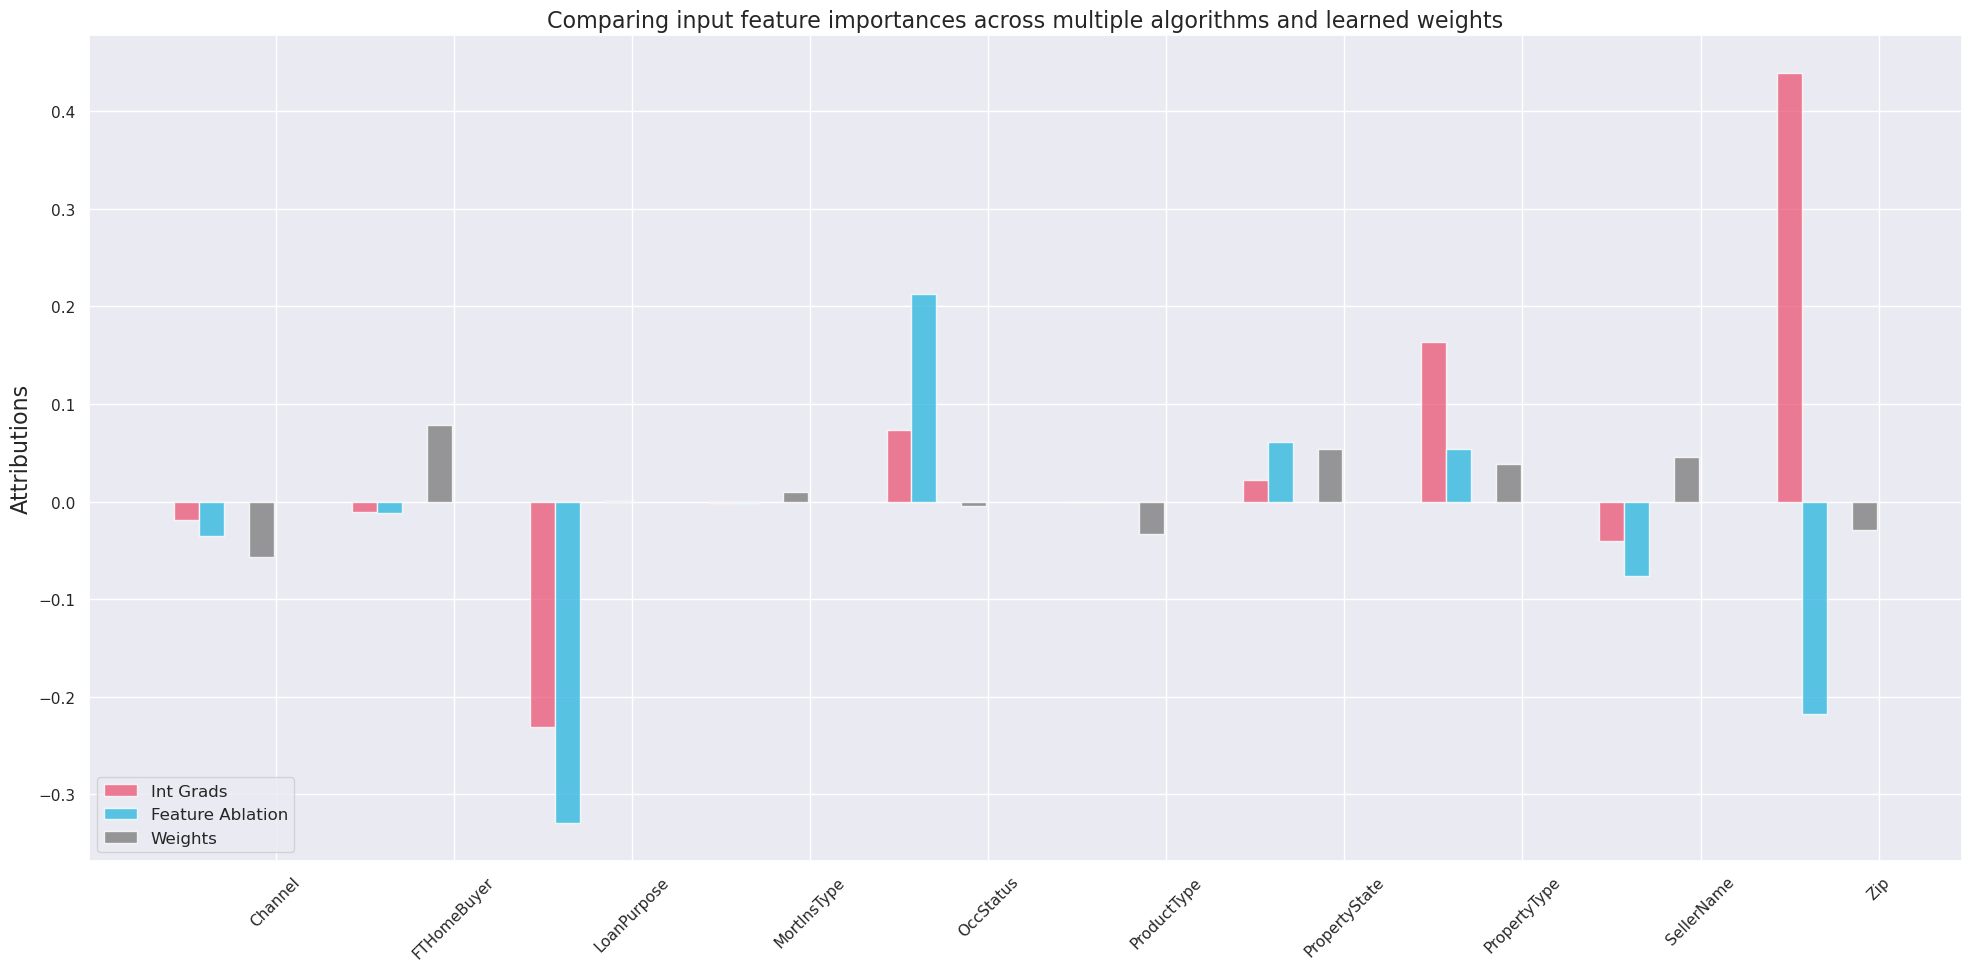

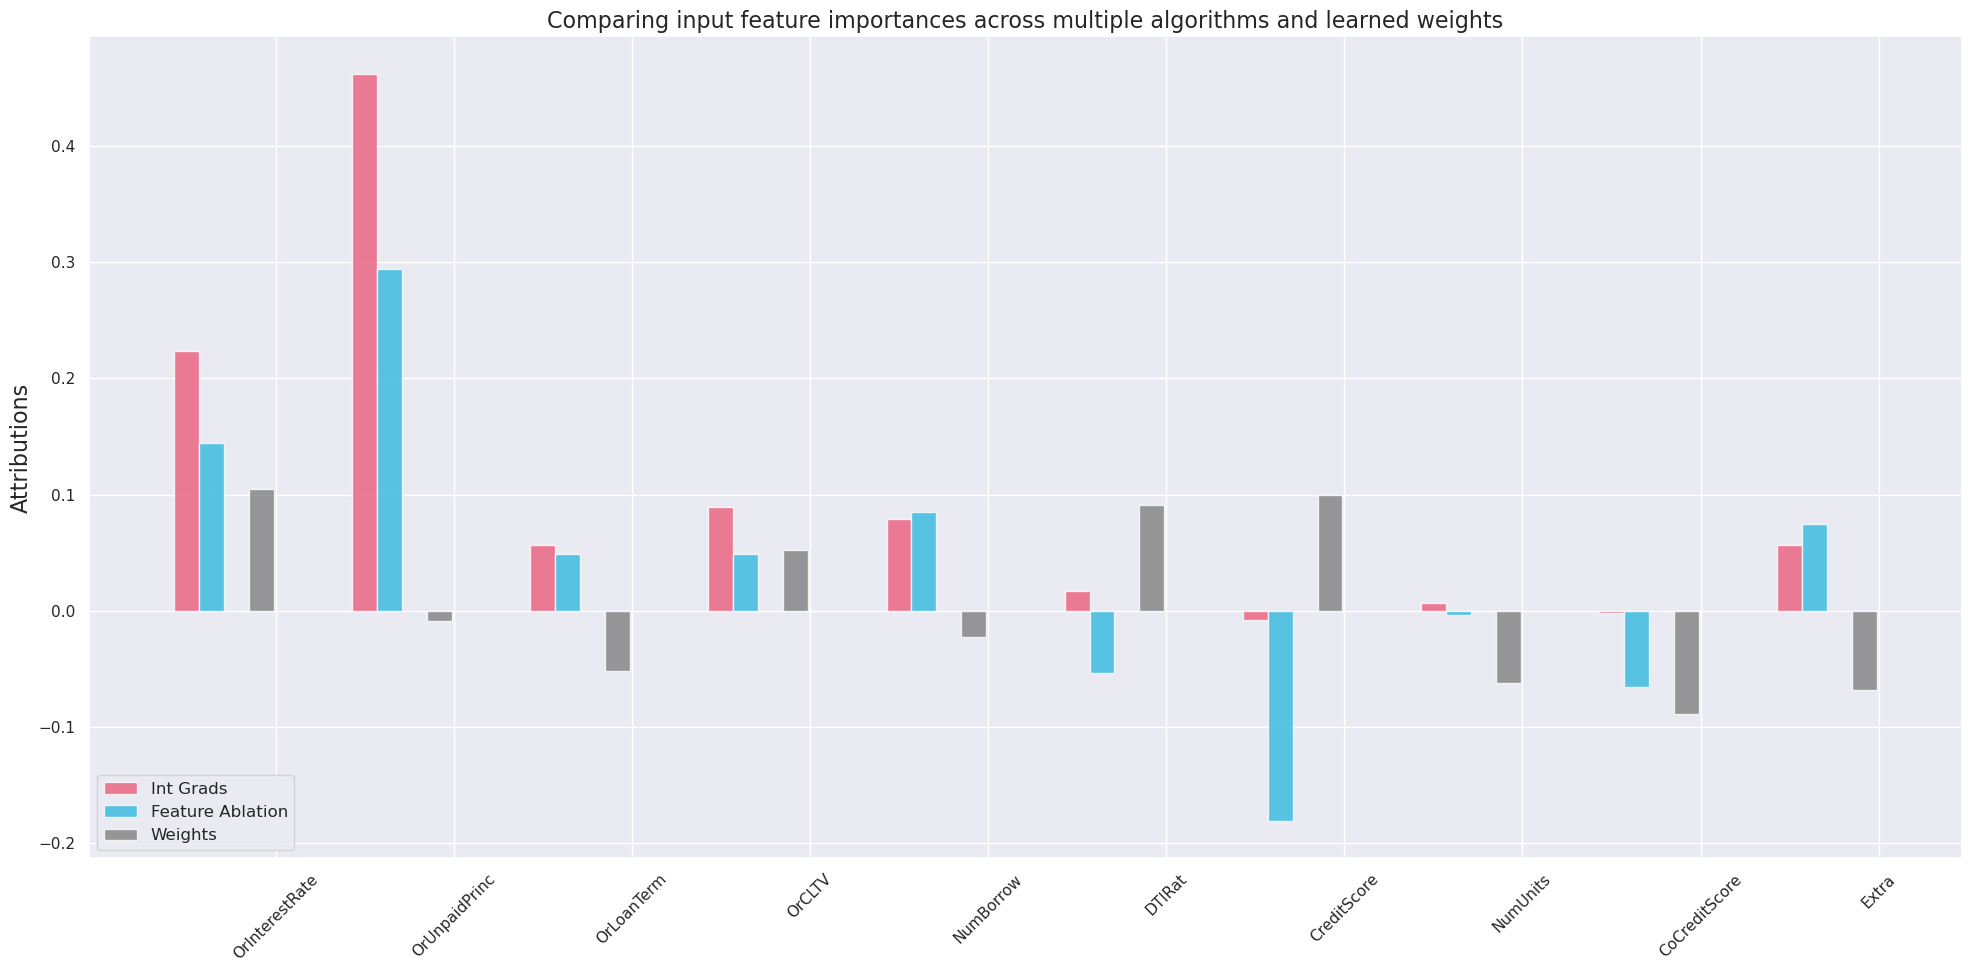

In [53]:
legends = ['Int Grads', 'Feature Ablation', 'Weights']
neg_attr_methds_cat = [ig_attr_neg_cat, fa_attr_neg_cat]
neg_attr_methd_cont = [ig_attr_neg_cont, fa_attr_neg_cont]
colors = ['#eb5e7c', '#34b8e0']

# Positive Class
plot_attributions(model.layer_1, (0, 10), pos_cats, CATEGORICAL_COLUMNS, 
                  neg_attr_methds_cat, legends, colors, save=f'{figures_path}/compare_cat_neg_class.png')
plot_attributions(model.layer_1, (10, 20), pos_conts, CONTINUOUS_COLUMNS, 
                  neg_attr_methd_cont, legends, colors, save=f'{figures_path}/compare_cont_neg_class.png')

In [54]:
end_time = time.time() - start_time

print(f'Total Runtime (s): {end_time: 0.3f} with {device}')


Total Runtime (s):  1448.102 with cuda:0


In [55]:
!lscpu | grep 'Model name' | xargs


Model name: Genuine Intel(R) CPU $0000%@


In [56]:
!nvidia-smi -i 0

Sat Nov  6 13:36:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:8A:00.0 Off |                    0 |
| N/A   29C    P0    35W / 250W |  29516MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [57]:
# Total Runtime (s):  186 with gpu with NVTabular
# Total Runtime (s):  194.509 179.166 with gpu with Pytorch Data Loader

# Total Runtime (s):  5455.410 with cpu with Pytorch Data Loader

# Model name: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
# V100 SXM2 32GB

# speedup of ~ 30x